In [2]:
import os
os.chdir('./..')

In [3]:
import pandas as pd
import data
from tqdm import tqdm
tqdm.pandas()
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
import xgboost as xgb
import numpy as np
from sklearn.model_selection import train_test_split

In [4]:
train_df = data.train_df('small')

In [5]:
clickout_train_df = train_df[train_df['action_type'] == 'clickout item']
print(clickout_train_df)

              user_id     session_id   timestamp  step    action_type  \
13       00RL8Z82B2Z1  aff3928535f48  1541037543    14  clickout item   
15       00RL8Z82B2Z1  aff3928535f48  1541038485    16  clickout item   
115      02SRUT1NQYH1  3599a6f709eab  1541063864    35  clickout item   
121      03K8AXBL4BX2  ec139e10b9238  1541100322     6  clickout item   
122      03K8AXBL4BX2  ec139e10b9238  1541100652     7  clickout item   
176      03P4VFKK12UO  325fafb5fa450  1541107500    54  clickout item   
177      03P4VFKK12UO  325fafb5fa450  1541107538    55  clickout item   
180      0473FZ8UNXRS  bcc452f3350eb  1541062532     3  clickout item   
181      066TUPQWUEV5  7157899be2839  1541102679     1  clickout item   
184      06S61EKCW1JY  22b9deb2da8f7  1541075258     1  clickout item   
188      06SZHKMYOOI8  4c6062d7cefe4  1541104565     4  clickout item   
191      06SZHKMYOOI8  4c6062d7cefe4  1541104659     7  clickout item   
196      098CQXLJZ868  489f31ee6fca9  1541073724   

In [86]:
indexes = []
click_index = list(clickout_train_df.index)
for i in click_index:
    indexes.append(i-1)
    indexes.append(i)

In [87]:
df_ac_click = train_df.loc[indexes].reset_index(drop = True)
df_ac_click['is_numeric'] = df_ac_click['reference'].str.isnumeric()
print(df_ac_click)

             user_id     session_id     timestamp   step  \
0       00RL8Z82B2Z1  aff3928535f48  1.541038e+09   13.0   
1       00RL8Z82B2Z1  aff3928535f48  1.541038e+09   14.0   
2       00RL8Z82B2Z1  aff3928535f48  1.541038e+09   15.0   
3       00RL8Z82B2Z1  aff3928535f48  1.541038e+09   16.0   
4       02SRUT1NQYH1  3599a6f709eab  1.541064e+09   34.0   
5       02SRUT1NQYH1  3599a6f709eab  1.541064e+09   35.0   
6       03K8AXBL4BX2  ec139e10b9238  1.541100e+09    5.0   
7       03K8AXBL4BX2  ec139e10b9238  1.541100e+09    6.0   
8       03K8AXBL4BX2  ec139e10b9238  1.541100e+09    6.0   
9       03K8AXBL4BX2  ec139e10b9238  1.541101e+09    7.0   
10      03P4VFKK12UO  325fafb5fa450  1.541107e+09   53.0   
11      03P4VFKK12UO  325fafb5fa450  1.541108e+09   54.0   
12      03P4VFKK12UO  325fafb5fa450  1.541108e+09   54.0   
13      03P4VFKK12UO  325fafb5fa450  1.541108e+09   55.0   
14      0473FZ8UNXRS  bcc452f3350eb  1.541062e+09    2.0   
15      0473FZ8UNXRS  bcc452f3350eb  1.5

/home/edoardo/miniconda3/envs/recsys/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.


In [89]:
data_dict = {}
for i in tqdm(range(0,len(df_ac_click),2)):
    couple = df_ac_click.loc[[i, i+1]]
    past_action_row = df_ac_click.loc[i]
    clickout_row = df_ac_click.loc[i+1]
    session_id = couple['session_id'].unique()
    # not valid sample
    if len(session_id)>1:
        continue
    
    past_action_row = df_ac_click.loc[i]
    clickout_row = df_ac_click.loc[i+1]
    
    impr = list(map(int, couple.tail(1)['impressions'].values[0].split('|')))
    user_position = 0
    if past_action_row['is_numeric'] == True:
        ref = int(past_action_row['reference'])
        if ref in impr:
            user_position = impr.index(ref)
    
    real_click = int(clickout_row['reference'])
    if real_click in impr:
        final_pos = impr.index(real_click)
    else:
        continue
    time_elapsed = clickout_row['timestamp']-past_action_row['timestamp']
    action_before_clickout = past_action_row['action_type']
    delta_position = final_pos-user_position
    step = clickout_row['step']
    timestamp = clickout_row['timestamp']
    
    datum=(user_position, time_elapsed, delta_position)
    if action_before_clickout in data_dict:
        data_dict[action_before_clickout].append(datum)
    else:
        data_dict[action_before_clickout]=[datum]


 24%|██▎       | 18846/80073 [00:29<01:32, 659.44it/s]


 47%|████▋     | 37628/80073 [00:58<01:09, 610.38it/s]


 69%|██████▉   | 55515/80073 [01:28<00:39, 625.53it/s]


 93%|█████████▎| 74306/80073 [01:57<00:08, 665.57it/s]


100%|██████████| 80073/80073 [02:06<00:00, 634.69it/s]

In [59]:
data_dict.keys()

dict_keys(['interaction item image', 'search for poi', 'interaction item info', 'clickout item', 'search for item', 'filter selection', 'interaction item rating', 'interaction item deals', 'search for destination', 'change of sort order'])

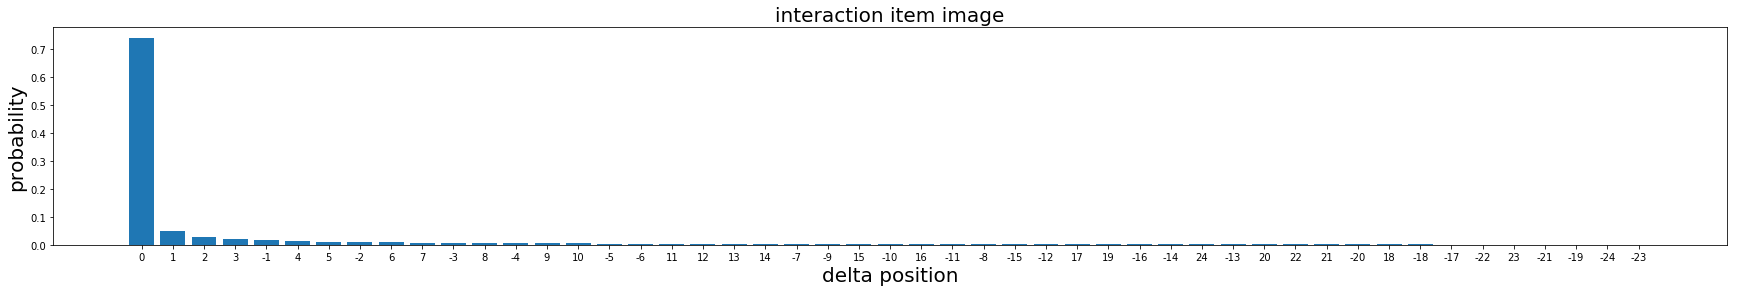

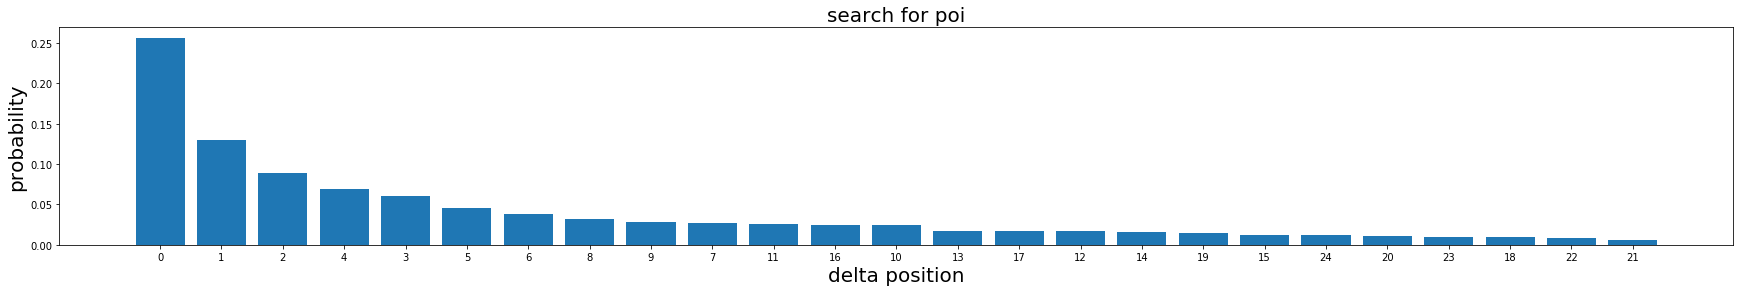

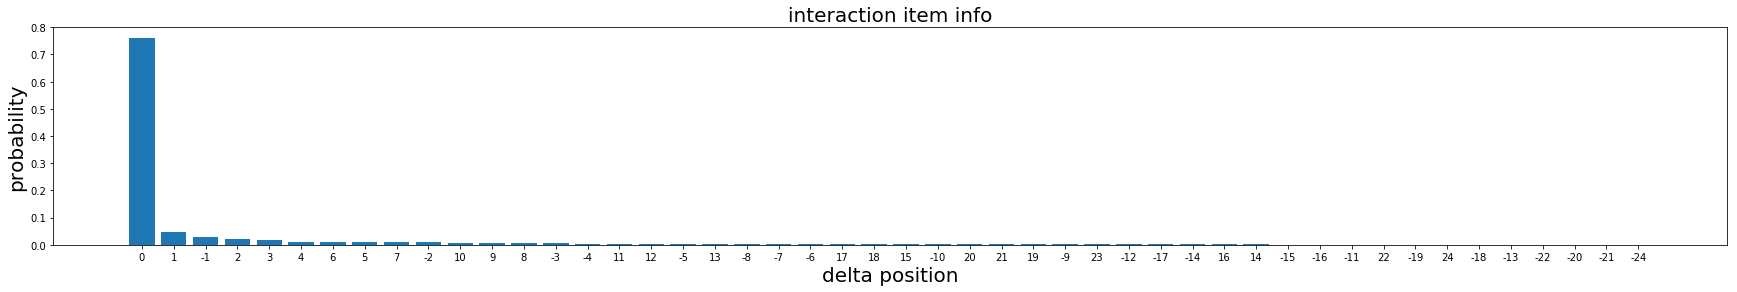

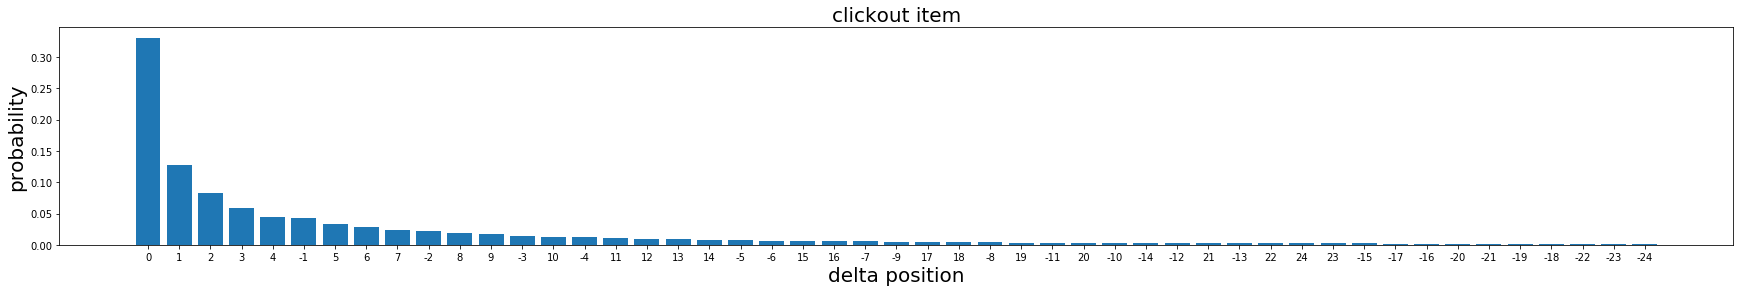

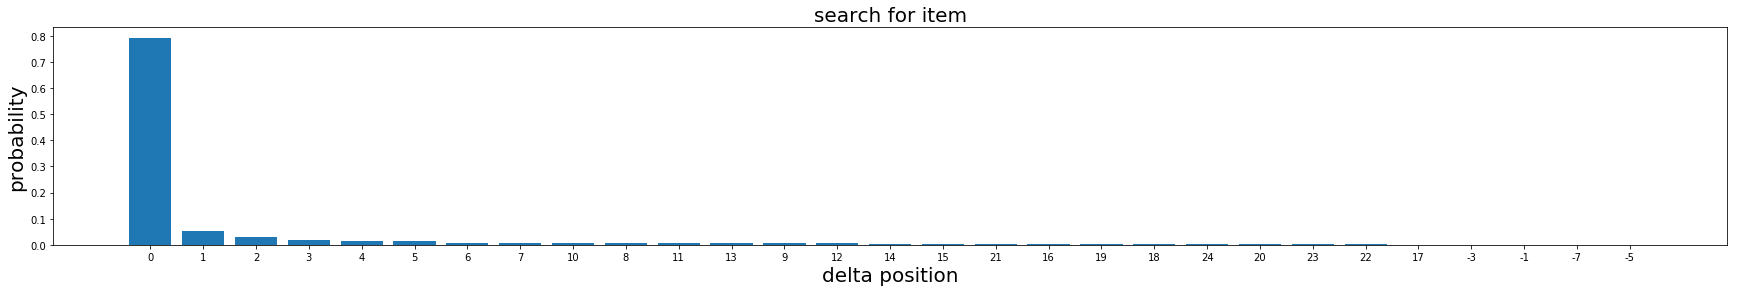

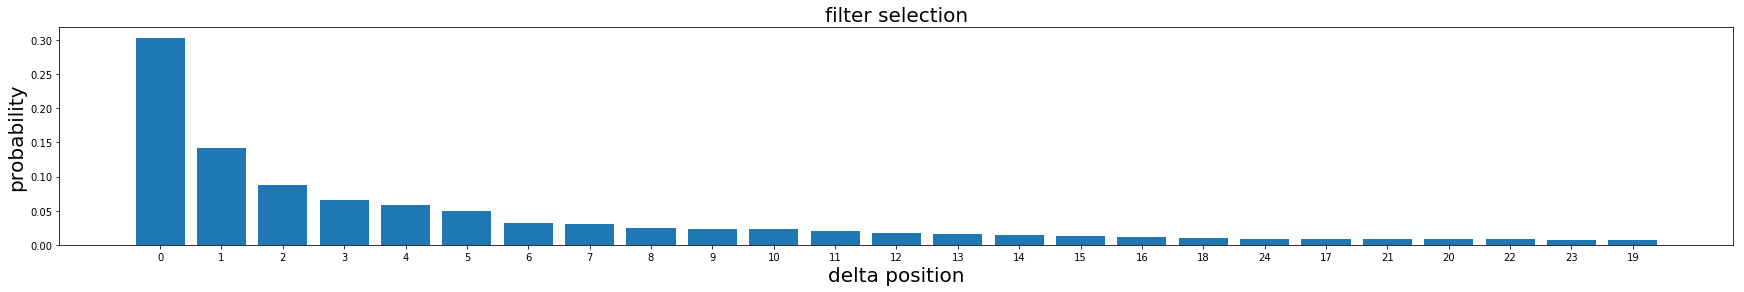

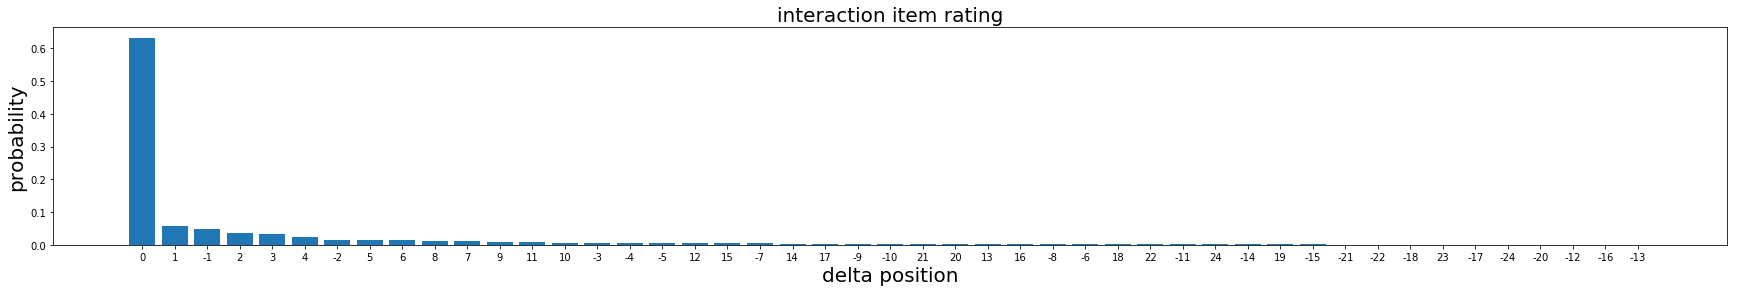

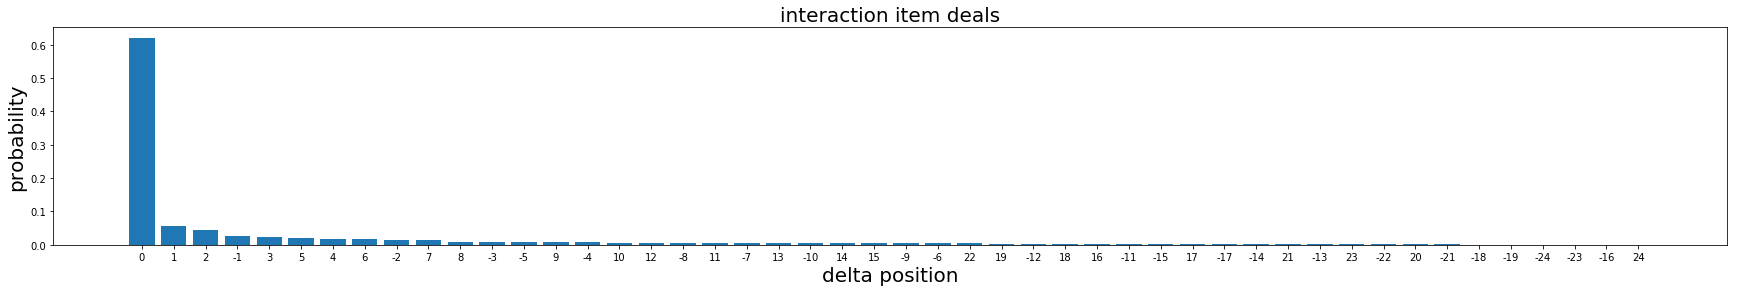

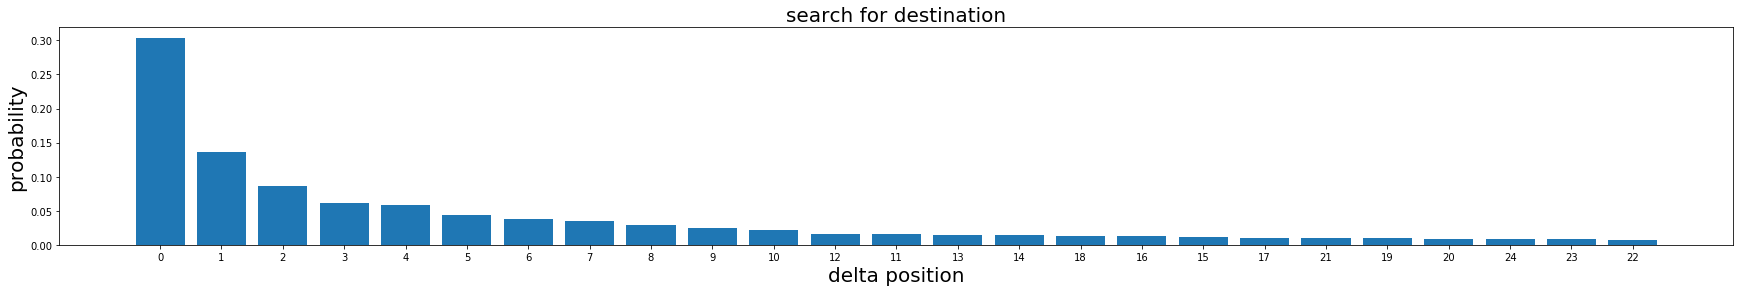

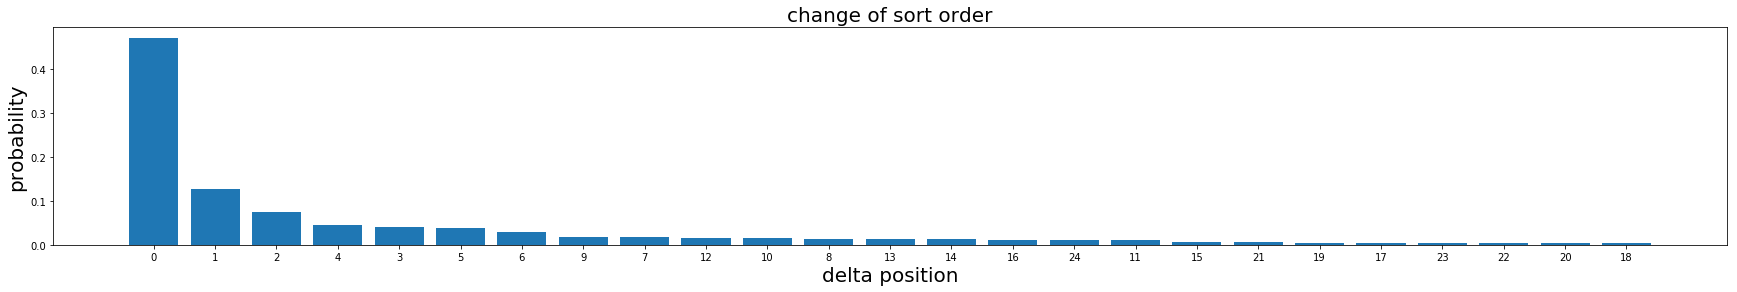

In [172]:
for label in data_dict.keys():
    count = 0
    delta_pos_dict = {}
    for d in data_dict[label]:
        count += 1
        delta = d[2]
        if delta in delta_pos_dict:
            delta_pos_dict[delta]+=1
        else:
            delta_pos_dict[delta]=1
    delta_pos_list = sorted(delta_pos_dict.items(), key=lambda kv: kv[1], reverse=True)
    plt.bar(range(len(delta_pos_list)), [a[1]/count for a in delta_pos_list], align='center')
    plt.xticks(range(len(delta_pos_list)), [a[0] for a in delta_pos_list])
    plt.rcParams["figure.figsize"] = (30,4)
    plt.title(label, size = 20)
    plt.xlabel('delta position',size=20)
    plt.ylabel('probability', size = 20)
    plt.show()

In [223]:
def get_session_score(df):
    click_row = df[(df['action_type'] == 'clickout item') & (df['is_numeric'].isnull())]
    if len(click_row) > 0:
        #get the keys
        final_row = click_row[['user_id', 'session_id', 'timestamp', 'step']]
        
        indx_click = click_row.index
        impr = list(map(int, df.loc[indx_click]['impressions'].values[0].split('|')))
        indx_before_click = indx_click-1
        index_list = list(df.index)
        impr_reordered = []
        if indx_before_click in index_list:
            action_row = df.loc[indx_before_click]
            if action_row['is_numeric'].values == True:
                last_ref = int(action_row['reference'])
                if last_ref in impr:
                    pos = impr.index(last_ref)

                    #TODO: RETRIEVE THE LIST
                    # list
                    delta_pos_dict = {}
                    for d in data_dict[action_row['action_type'].values[0]]:
                        delta = d[2]
                        if delta in delta_pos_dict:
                            delta_pos_dict[delta] += 1
                        else:
                            delta_pos_dict[delta] = 1
                    
                    delta_pos_list = sorted(delta_pos_dict.items(), key=lambda kv: kv[1], reverse=True)
                    _list = [a[0] for a in delta_pos_list]

                    for i in range(len(_list)):
                        index = pos+i
                        if (index < len(impr) and index > -1):
                            impr_reordered.append(impr[index])
                    impr_reordered = " ".join(list(map(str,impr_reordered)))
                    #print(impr_reordered)
                    final_row['item_recommendations'] = impr_reordered
                    #print(f'reordered{impr_reordered}')
        if len(impr_reordered) == 0:
            impr_reordered = impr
            impr_reordered = " ".join(list(map(str,impr_reordered)))
            final_row['item_recommendations'] = impr_reordered
        return final_row


In [226]:
# load the full df_test
test_df = data.test_df(mode='full')

# add a column that says id the reference is numeric
test_df['is_numeric'] = test_df['reference'].str.isnumeric()

sub = test_df.groupby(['user_id', 'session_id']).progress_apply(get_session_score)








  0%|          | 0/291381 [00:00<?, ?it/s]





  0%|          | 1/291381 [00:01<97:26:26,  1.20s/it]





  0%|          | 24/291381 [00:01<68:18:35,  1.18it/s]





  0%|          | 42/291381 [00:01<47:57:07,  1.69it/s]





  0%|          | 67/291381 [00:01<33:39:39,  2.40it/s]





  0%|          | 90/291381 [00:01<23:40:10,  3.42it/s]





  0%|          | 115/291381 [00:01<16:40:10,  4.85it/s]





  0%|          | 143/291381 [00:01<11:45:28,  6.88it/s]





  0%|          | 165/291381 [00:01<8:20:59,  9.69it/s] 





  0%|          | 189/291381 [00:02<5:56:46, 13.60it/s]





  0%|          | 212/291381 [00:02<4:16:20, 18.93it/s]





  0%|          | 238/291381 [00:02<3:05:04, 26.22it/s]





  0%|          | 262/291381 [00:02<2:16:59, 35.42it/s]





  0%|          | 284/291381 [00:02<1:43:02, 47.08it/s]





  0%|          | 310/291381 [00:02<1:17:57, 62.22it/s]





  0%|          | 333/291381 [00:02<1:01:17, 79.14it/s]





  0%|          | 357/291381 [00:02<49:02, 98

  2%|▏         | 4874/291381 [00:23<20:32, 232.43it/s]





  2%|▏         | 4898/291381 [00:24<21:28, 222.34it/s]





  2%|▏         | 4924/291381 [00:24<20:43, 230.38it/s]





  2%|▏         | 4948/291381 [00:24<21:03, 226.73it/s]





  2%|▏         | 4973/291381 [00:24<20:38, 231.16it/s]





  2%|▏         | 4999/291381 [00:24<20:13, 236.08it/s]





  2%|▏         | 5024/291381 [00:24<20:07, 237.18it/s]





  2%|▏         | 5048/291381 [00:24<20:32, 232.35it/s]





  2%|▏         | 5072/291381 [00:24<21:10, 225.28it/s]





  2%|▏         | 5097/291381 [00:24<20:36, 231.47it/s]





  2%|▏         | 5121/291381 [00:24<21:21, 223.41it/s]





  2%|▏         | 5144/291381 [00:25<22:10, 215.07it/s]





  2%|▏         | 5169/291381 [00:25<21:19, 223.69it/s]





  2%|▏         | 5192/291381 [00:25<21:15, 224.34it/s]





  2%|▏         | 5215/291381 [00:25<22:05, 215.84it/s]





  2%|▏         | 5241/291381 [00:25<21:15, 224.28it/s]





  2%|▏         | 5264/291381 [00:25<21:2

  3%|▎         | 10011/291381 [00:46<23:01, 203.65it/s]





  3%|▎         | 10032/291381 [00:46<23:06, 202.91it/s]





  3%|▎         | 10061/291381 [00:46<21:17, 220.30it/s]





  3%|▎         | 10086/291381 [00:46<20:46, 225.62it/s]





  3%|▎         | 10109/291381 [00:46<20:46, 225.69it/s]





  3%|▎         | 10132/291381 [00:47<20:42, 226.38it/s]





  3%|▎         | 10157/291381 [00:47<20:26, 229.29it/s]





  3%|▎         | 10181/291381 [00:47<20:33, 227.98it/s]





  4%|▎         | 10205/291381 [00:47<20:17, 231.00it/s]





  4%|▎         | 10230/291381 [00:47<19:56, 235.05it/s]





  4%|▎         | 10260/291381 [00:47<18:39, 251.06it/s]





  4%|▎         | 10286/291381 [00:47<18:54, 247.77it/s]





  4%|▎         | 10312/291381 [00:47<18:58, 246.78it/s]





  4%|▎         | 10343/291381 [00:47<17:53, 261.69it/s]





  4%|▎         | 10370/291381 [00:48<18:21, 255.15it/s]





  4%|▎         | 10396/291381 [00:48<19:53, 235.48it/s]





  4%|▎         | 10421/2

  5%|▌         | 15308/291381 [01:08<17:59, 255.80it/s]





  5%|▌         | 15334/291381 [01:09<18:31, 248.36it/s]





  5%|▌         | 15362/291381 [01:09<17:57, 256.06it/s]





  5%|▌         | 15389/291381 [01:09<17:46, 258.90it/s]





  5%|▌         | 15416/291381 [01:09<18:50, 244.06it/s]





  5%|▌         | 15441/291381 [01:09<19:10, 239.77it/s]





  5%|▌         | 15467/291381 [01:09<18:44, 245.34it/s]





  5%|▌         | 15492/291381 [01:09<19:02, 241.50it/s]





  5%|▌         | 15517/291381 [01:09<19:23, 237.09it/s]





  5%|▌         | 15541/291381 [01:09<20:31, 223.98it/s]





  5%|▌         | 15564/291381 [01:10<20:39, 222.52it/s]





  5%|▌         | 15587/291381 [01:10<20:44, 221.57it/s]





  5%|▌         | 15610/291381 [01:10<20:32, 223.79it/s]





  5%|▌         | 15633/291381 [01:10<20:49, 220.69it/s]





  5%|▌         | 15662/291381 [01:10<19:31, 235.42it/s]





  5%|▌         | 15686/291381 [01:10<19:27, 236.21it/s]





  5%|▌         | 15711/2

  7%|▋         | 20378/291381 [01:31<19:50, 227.55it/s]





  7%|▋         | 20402/291381 [01:31<19:50, 227.62it/s]





  7%|▋         | 20427/291381 [01:31<19:21, 233.27it/s]





  7%|▋         | 20452/291381 [01:31<19:03, 236.85it/s]





  7%|▋         | 20476/291381 [01:31<19:16, 234.21it/s]





  7%|▋         | 20506/291381 [01:31<18:01, 250.42it/s]





  7%|▋         | 20532/291381 [01:32<19:03, 236.79it/s]





  7%|▋         | 20557/291381 [01:32<19:26, 232.20it/s]





  7%|▋         | 20581/291381 [01:32<19:40, 229.43it/s]





  7%|▋         | 20606/291381 [01:32<19:11, 235.17it/s]





  7%|▋         | 20630/291381 [01:32<20:59, 214.99it/s]





  7%|▋         | 20654/291381 [01:32<20:21, 221.58it/s]





  7%|▋         | 20679/291381 [01:32<19:57, 225.99it/s]





  7%|▋         | 20704/291381 [01:32<19:29, 231.40it/s]





  7%|▋         | 20728/291381 [01:32<19:35, 230.22it/s]





  7%|▋         | 20755/291381 [01:32<18:43, 240.86it/s]





  7%|▋         | 20780/2

  9%|▉         | 25535/291381 [01:53<18:06, 244.76it/s]





  9%|▉         | 25561/291381 [01:53<18:01, 245.87it/s]





  9%|▉         | 25586/291381 [01:53<18:10, 243.68it/s]





  9%|▉         | 25611/291381 [01:53<18:11, 243.38it/s]





  9%|▉         | 25636/291381 [01:54<18:13, 242.93it/s]





  9%|▉         | 25661/291381 [01:54<18:41, 236.96it/s]





  9%|▉         | 25685/291381 [01:54<18:46, 235.87it/s]





  9%|▉         | 25709/291381 [01:54<18:41, 236.97it/s]





  9%|▉         | 25737/291381 [01:54<17:51, 247.81it/s]





  9%|▉         | 25767/291381 [01:54<17:08, 258.29it/s]





  9%|▉         | 25795/291381 [01:54<16:48, 263.40it/s]





  9%|▉         | 25822/291381 [01:54<17:00, 260.14it/s]





  9%|▉         | 25849/291381 [01:54<17:07, 258.55it/s]





  9%|▉         | 25875/291381 [01:55<17:56, 246.56it/s]





  9%|▉         | 25903/291381 [01:55<17:24, 254.18it/s]





  9%|▉         | 25931/291381 [01:55<17:00, 260.21it/s]





  9%|▉         | 25958/2

 11%|█         | 30716/291381 [02:15<18:14, 238.27it/s]





 11%|█         | 30741/291381 [02:15<19:14, 225.78it/s]





 11%|█         | 30766/291381 [02:15<18:45, 231.61it/s]





 11%|█         | 30790/291381 [02:16<19:11, 226.34it/s]





 11%|█         | 30813/291381 [02:16<19:59, 217.22it/s]





 11%|█         | 30835/291381 [02:16<20:14, 214.61it/s]





 11%|█         | 30861/291381 [02:16<19:19, 224.70it/s]





 11%|█         | 30891/291381 [02:16<17:56, 242.06it/s]





 11%|█         | 30916/291381 [02:16<27:12, 159.58it/s]





 11%|█         | 30937/291381 [02:16<25:58, 167.09it/s]





 11%|█         | 30963/291381 [02:17<23:22, 185.70it/s]





 11%|█         | 30985/291381 [02:17<22:30, 192.85it/s]





 11%|█         | 31007/291381 [02:17<22:04, 196.63it/s]





 11%|█         | 31029/291381 [02:17<21:49, 198.83it/s]





 11%|█         | 31054/291381 [02:17<20:43, 209.42it/s]





 11%|█         | 31082/291381 [02:17<19:21, 224.13it/s]





 11%|█         | 31113/2

 12%|█▏        | 35890/291381 [02:38<18:18, 232.60it/s]





 12%|█▏        | 35917/291381 [02:38<17:38, 241.46it/s]





 12%|█▏        | 35942/291381 [02:38<18:35, 228.96it/s]





 12%|█▏        | 35967/291381 [02:38<18:16, 233.02it/s]





 12%|█▏        | 35991/291381 [02:38<18:12, 233.73it/s]





 12%|█▏        | 36015/291381 [02:38<20:37, 206.30it/s]





 12%|█▏        | 36038/291381 [02:38<20:10, 211.02it/s]





 12%|█▏        | 36060/291381 [02:38<20:53, 203.65it/s]





 12%|█▏        | 36083/291381 [02:39<20:21, 209.06it/s]





 12%|█▏        | 36108/291381 [02:39<19:35, 217.12it/s]





 12%|█▏        | 36133/291381 [02:39<18:55, 224.83it/s]





 12%|█▏        | 36158/291381 [02:39<18:23, 231.29it/s]





 12%|█▏        | 36182/291381 [02:39<18:28, 230.28it/s]





 12%|█▏        | 36211/291381 [02:39<17:21, 244.93it/s]





 12%|█▏        | 36236/291381 [02:39<18:16, 232.59it/s]





 12%|█▏        | 36263/291381 [02:39<17:39, 240.72it/s]





 12%|█▏        | 36288/2

 14%|█▍        | 40999/291381 [03:00<18:55, 220.58it/s]





 14%|█▍        | 41022/291381 [03:00<20:06, 207.44it/s]





 14%|█▍        | 41044/291381 [03:00<20:01, 208.40it/s]





 14%|█▍        | 41066/291381 [03:01<20:07, 207.28it/s]





 14%|█▍        | 41087/291381 [03:01<20:58, 198.81it/s]





 14%|█▍        | 41108/291381 [03:01<21:39, 192.59it/s]





 14%|█▍        | 41134/291381 [03:01<19:58, 208.75it/s]





 14%|█▍        | 41156/291381 [03:01<20:23, 204.52it/s]





 14%|█▍        | 41180/291381 [03:01<19:30, 213.74it/s]





 14%|█▍        | 41206/291381 [03:01<18:28, 225.71it/s]





 14%|█▍        | 41230/291381 [03:01<18:35, 224.17it/s]





 14%|█▍        | 41254/291381 [03:01<18:23, 226.71it/s]





 14%|█▍        | 41277/291381 [03:01<19:34, 213.00it/s]





 14%|█▍        | 41299/291381 [03:02<19:32, 213.20it/s]





 14%|█▍        | 41321/291381 [03:02<19:36, 212.56it/s]





 14%|█▍        | 41343/291381 [03:02<19:51, 209.82it/s]





 14%|█▍        | 41365/2

 16%|█▌        | 45765/291381 [03:23<21:33, 189.94it/s]





 16%|█▌        | 45785/291381 [03:23<21:58, 186.25it/s]





 16%|█▌        | 45804/291381 [03:23<22:55, 178.53it/s]





 16%|█▌        | 45825/291381 [03:23<22:22, 182.91it/s]





 16%|█▌        | 45844/291381 [03:23<22:39, 180.66it/s]





 16%|█▌        | 45866/291381 [03:23<21:31, 190.11it/s]





 16%|█▌        | 45886/291381 [03:24<21:30, 190.30it/s]





 16%|█▌        | 45907/291381 [03:24<21:03, 194.35it/s]





 16%|█▌        | 45932/291381 [03:24<19:40, 207.97it/s]





 16%|█▌        | 45954/291381 [03:24<19:39, 208.07it/s]





 16%|█▌        | 45980/291381 [03:24<18:32, 220.65it/s]





 16%|█▌        | 46003/291381 [03:24<19:26, 210.38it/s]





 16%|█▌        | 46026/291381 [03:24<18:56, 215.89it/s]





 16%|█▌        | 46048/291381 [03:24<19:17, 211.87it/s]





 16%|█▌        | 46071/291381 [03:24<18:51, 216.74it/s]





 16%|█▌        | 46093/291381 [03:24<18:56, 215.91it/s]





 16%|█▌        | 46115/2

 17%|█▋        | 50754/291381 [03:45<17:48, 225.23it/s]





 17%|█▋        | 50782/291381 [03:45<16:51, 237.76it/s]





 17%|█▋        | 50807/291381 [03:46<16:51, 237.91it/s]





 17%|█▋        | 50833/291381 [03:46<16:30, 242.77it/s]





 17%|█▋        | 50858/291381 [03:46<17:41, 226.59it/s]





 17%|█▋        | 50882/291381 [03:46<18:12, 220.04it/s]





 17%|█▋        | 50906/291381 [03:46<18:02, 222.19it/s]





 17%|█▋        | 50929/291381 [03:46<17:55, 223.66it/s]





 17%|█▋        | 50952/291381 [03:46<18:07, 220.99it/s]





 17%|█▋        | 50975/291381 [03:46<18:39, 214.68it/s]





 18%|█▊        | 51000/291381 [03:46<17:54, 223.78it/s]





 18%|█▊        | 51025/291381 [03:47<17:20, 230.98it/s]





 18%|█▊        | 51051/291381 [03:47<16:51, 237.51it/s]





 18%|█▊        | 51079/291381 [03:47<16:12, 247.05it/s]





 18%|█▊        | 51104/291381 [03:47<16:58, 235.90it/s]





 18%|█▊        | 51128/291381 [03:47<17:28, 229.05it/s]





 18%|█▊        | 51152/2

 19%|█▉        | 55894/291381 [04:07<18:17, 214.52it/s]





 19%|█▉        | 55916/291381 [04:08<18:23, 213.40it/s]





 19%|█▉        | 55941/291381 [04:08<17:36, 222.78it/s]





 19%|█▉        | 55967/291381 [04:08<16:59, 230.85it/s]





 19%|█▉        | 55991/291381 [04:08<16:52, 232.50it/s]





 19%|█▉        | 56015/291381 [04:08<16:57, 231.40it/s]





 19%|█▉        | 56039/291381 [04:08<17:36, 222.72it/s]





 19%|█▉        | 56063/291381 [04:08<17:24, 225.23it/s]





 19%|█▉        | 56086/291381 [04:08<17:48, 220.22it/s]





 19%|█▉        | 56114/291381 [04:08<16:40, 235.15it/s]





 19%|█▉        | 56138/291381 [04:09<16:57, 231.24it/s]





 19%|█▉        | 56162/291381 [04:09<17:44, 221.05it/s]





 19%|█▉        | 56186/291381 [04:09<17:21, 225.76it/s]





 19%|█▉        | 56210/291381 [04:09<17:17, 226.70it/s]





 19%|█▉        | 56240/291381 [04:09<16:05, 243.51it/s]





 19%|█▉        | 56265/291381 [04:09<16:13, 241.63it/s]





 19%|█▉        | 56291/2

 21%|██        | 61088/291381 [04:30<16:24, 233.97it/s]





 21%|██        | 61112/291381 [04:30<16:20, 234.81it/s]





 21%|██        | 61136/291381 [04:30<17:07, 224.03it/s]





 21%|██        | 61159/291381 [04:30<17:20, 221.37it/s]





 21%|██        | 61183/291381 [04:30<17:00, 225.62it/s]





 21%|██        | 61211/291381 [04:30<16:00, 239.58it/s]





 21%|██        | 61236/291381 [04:30<16:06, 238.18it/s]





 21%|██        | 61261/291381 [04:30<16:26, 233.17it/s]





 21%|██        | 61285/291381 [04:31<16:58, 225.86it/s]





 21%|██        | 61310/291381 [04:31<16:30, 232.23it/s]





 21%|██        | 61341/291381 [04:31<15:19, 250.26it/s]





 21%|██        | 61367/291381 [04:31<15:44, 243.42it/s]





 21%|██        | 61394/291381 [04:31<15:17, 250.68it/s]





 21%|██        | 61420/291381 [04:31<15:38, 245.07it/s]





 21%|██        | 61445/291381 [04:31<16:12, 236.46it/s]





 21%|██        | 61469/291381 [04:31<16:12, 236.51it/s]





 21%|██        | 61494/2

 23%|██▎       | 66192/291381 [04:52<16:44, 224.16it/s]





 23%|██▎       | 66215/291381 [04:52<16:37, 225.76it/s]





 23%|██▎       | 66238/291381 [04:52<17:20, 216.47it/s]





 23%|██▎       | 66262/291381 [04:52<16:59, 220.76it/s]





 23%|██▎       | 66285/291381 [04:53<17:03, 219.95it/s]





 23%|██▎       | 66315/291381 [04:53<15:44, 238.19it/s]





 23%|██▎       | 66343/291381 [04:53<15:11, 246.76it/s]





 23%|██▎       | 66369/291381 [04:53<15:41, 239.08it/s]





 23%|██▎       | 66394/291381 [04:53<16:36, 225.79it/s]





 23%|██▎       | 66417/291381 [04:53<17:20, 216.30it/s]





 23%|██▎       | 66440/291381 [04:53<17:03, 219.88it/s]





 23%|██▎       | 66463/291381 [04:53<17:15, 217.30it/s]





 23%|██▎       | 66491/291381 [04:53<16:06, 232.71it/s]





 23%|██▎       | 66518/291381 [04:54<15:28, 242.10it/s]





 23%|██▎       | 66543/291381 [04:54<15:42, 238.52it/s]





 23%|██▎       | 66569/291381 [04:54<15:21, 244.04it/s]





 23%|██▎       | 66594/2

 24%|██▍       | 71373/291381 [05:14<17:30, 209.41it/s]





 25%|██▍       | 71395/291381 [05:15<17:36, 208.16it/s]





 25%|██▍       | 71419/291381 [05:15<17:04, 214.70it/s]





 25%|██▍       | 71442/291381 [05:15<16:53, 217.01it/s]





 25%|██▍       | 71468/291381 [05:15<16:19, 224.41it/s]





 25%|██▍       | 71491/291381 [05:15<16:32, 221.65it/s]





 25%|██▍       | 71514/291381 [05:15<16:49, 217.89it/s]





 25%|██▍       | 71538/291381 [05:15<16:24, 223.26it/s]





 25%|██▍       | 71561/291381 [05:15<16:38, 220.11it/s]





 25%|██▍       | 71584/291381 [05:15<16:47, 218.20it/s]





 25%|██▍       | 71606/291381 [05:15<17:10, 213.29it/s]





 25%|██▍       | 71633/291381 [05:16<16:16, 225.03it/s]





 25%|██▍       | 71664/291381 [05:16<15:01, 243.65it/s]





 25%|██▍       | 71689/291381 [05:16<15:08, 241.82it/s]





 25%|██▍       | 71714/291381 [05:16<15:19, 238.92it/s]





 25%|██▍       | 71739/291381 [05:16<15:36, 234.46it/s]





 25%|██▍       | 71768/2

 26%|██▋       | 76536/291381 [05:37<16:16, 219.99it/s]





 26%|██▋       | 76559/291381 [05:37<16:29, 217.14it/s]





 26%|██▋       | 76581/291381 [05:37<16:53, 212.04it/s]





 26%|██▋       | 76603/291381 [05:37<17:29, 204.72it/s]





 26%|██▋       | 76629/291381 [05:37<16:26, 217.68it/s]





 26%|██▋       | 76652/291381 [05:37<16:11, 221.12it/s]





 26%|██▋       | 76675/291381 [05:37<16:21, 218.66it/s]





 26%|██▋       | 76698/291381 [05:37<16:14, 220.30it/s]





 26%|██▋       | 76726/291381 [05:37<15:20, 233.18it/s]





 26%|██▋       | 76751/291381 [05:38<15:05, 237.01it/s]





 26%|██▋       | 76781/291381 [05:38<14:12, 251.71it/s]





 26%|██▋       | 76807/291381 [05:38<14:46, 241.95it/s]





 26%|██▋       | 76832/291381 [05:38<15:05, 236.86it/s]





 26%|██▋       | 76856/291381 [05:38<15:25, 231.73it/s]





 26%|██▋       | 76881/291381 [05:38<15:22, 232.53it/s]





 26%|██▋       | 76906/291381 [05:38<15:04, 237.19it/s]





 26%|██▋       | 76930/2

 28%|██▊       | 81631/291381 [05:59<15:34, 224.35it/s]





 28%|██▊       | 81654/291381 [05:59<15:50, 220.58it/s]





 28%|██▊       | 81680/291381 [05:59<15:09, 230.51it/s]





 28%|██▊       | 81704/291381 [06:00<15:26, 226.27it/s]





 28%|██▊       | 81727/291381 [06:00<15:38, 223.43it/s]





 28%|██▊       | 81753/291381 [06:00<15:00, 232.80it/s]





 28%|██▊       | 81777/291381 [06:00<15:22, 227.11it/s]





 28%|██▊       | 81800/291381 [06:00<15:35, 224.12it/s]





 28%|██▊       | 81823/291381 [06:00<15:35, 223.93it/s]





 28%|██▊       | 81846/291381 [06:00<15:32, 224.70it/s]





 28%|██▊       | 81869/291381 [06:00<16:07, 216.65it/s]





 28%|██▊       | 81891/291381 [06:00<16:03, 217.46it/s]





 28%|██▊       | 81914/291381 [06:00<15:56, 218.92it/s]





 28%|██▊       | 81936/291381 [06:01<16:12, 215.37it/s]





 28%|██▊       | 81960/291381 [06:01<15:44, 221.62it/s]





 28%|██▊       | 81986/291381 [06:01<15:15, 228.74it/s]





 28%|██▊       | 82014/2

 30%|██▉       | 86736/291381 [06:21<14:26, 236.13it/s]





 30%|██▉       | 86762/291381 [06:21<14:08, 241.20it/s]





 30%|██▉       | 86787/291381 [06:21<14:05, 242.00it/s]





 30%|██▉       | 86817/291381 [06:22<13:22, 254.88it/s]





 30%|██▉       | 86843/291381 [06:22<14:10, 240.63it/s]





 30%|██▉       | 86871/291381 [06:22<13:34, 251.03it/s]





 30%|██▉       | 86897/291381 [06:22<13:44, 248.13it/s]





 30%|██▉       | 86923/291381 [06:22<15:02, 226.59it/s]





 30%|██▉       | 86948/291381 [06:22<14:46, 230.59it/s]





 30%|██▉       | 86972/291381 [06:22<15:05, 225.73it/s]





 30%|██▉       | 86998/291381 [06:22<14:31, 234.58it/s]





 30%|██▉       | 87022/291381 [06:22<14:47, 230.32it/s]





 30%|██▉       | 87051/291381 [06:23<13:53, 245.20it/s]





 30%|██▉       | 87077/291381 [06:23<13:39, 249.38it/s]





 30%|██▉       | 87105/291381 [06:23<13:17, 256.09it/s]





 30%|██▉       | 87131/291381 [06:23<13:23, 254.19it/s]





 30%|██▉       | 87160/2

 32%|███▏      | 91953/291381 [06:44<13:58, 237.70it/s]





 32%|███▏      | 91977/291381 [06:44<14:26, 230.23it/s]





 32%|███▏      | 92001/291381 [06:44<14:28, 229.45it/s]





 32%|███▏      | 92025/291381 [06:44<14:18, 232.17it/s]





 32%|███▏      | 92049/291381 [06:44<15:06, 220.00it/s]





 32%|███▏      | 92072/291381 [06:44<15:10, 218.84it/s]





 32%|███▏      | 92099/291381 [06:44<14:19, 231.87it/s]





 32%|███▏      | 92125/291381 [06:44<13:53, 238.97it/s]





 32%|███▏      | 92153/291381 [06:44<13:30, 245.89it/s]





 32%|███▏      | 92180/291381 [06:44<13:19, 249.30it/s]





 32%|███▏      | 92206/291381 [06:45<13:19, 249.02it/s]





 32%|███▏      | 92232/291381 [06:45<14:05, 235.42it/s]





 32%|███▏      | 92256/291381 [06:45<14:56, 222.16it/s]





 32%|███▏      | 92279/291381 [06:45<14:50, 223.56it/s]





 32%|███▏      | 92304/291381 [06:45<14:31, 228.35it/s]





 32%|███▏      | 92330/291381 [06:45<14:01, 236.67it/s]





 32%|███▏      | 92357/2

 33%|███▎      | 96843/291381 [07:06<15:09, 213.86it/s]





 33%|███▎      | 96866/291381 [07:06<14:57, 216.80it/s]





 33%|███▎      | 96888/291381 [07:06<15:57, 203.15it/s]





 33%|███▎      | 96916/291381 [07:07<14:40, 220.90it/s]





 33%|███▎      | 96939/291381 [07:07<14:42, 220.28it/s]





 33%|███▎      | 96964/291381 [07:07<14:12, 228.11it/s]





 33%|███▎      | 96988/291381 [07:07<14:05, 229.94it/s]





 33%|███▎      | 97012/291381 [07:07<14:12, 228.04it/s]





 33%|███▎      | 97035/291381 [07:07<14:22, 225.32it/s]





 33%|███▎      | 97060/291381 [07:07<13:58, 231.75it/s]





 33%|███▎      | 97084/291381 [07:07<14:28, 223.64it/s]





 33%|███▎      | 97107/291381 [07:07<14:35, 221.94it/s]





 33%|███▎      | 97130/291381 [07:07<14:43, 219.95it/s]





 33%|███▎      | 97155/291381 [07:08<14:12, 227.78it/s]





 33%|███▎      | 97183/291381 [07:08<13:26, 240.82it/s]





 33%|███▎      | 97208/291381 [07:08<13:29, 240.01it/s]





 33%|███▎      | 97233/2

 35%|███▍      | 101860/291381 [07:29<14:59, 210.72it/s]





 35%|███▍      | 101882/291381 [07:29<15:51, 199.11it/s]





 35%|███▍      | 101903/291381 [07:29<16:42, 189.10it/s]





 35%|███▍      | 101923/291381 [07:29<16:27, 191.93it/s]





 35%|███▍      | 101943/291381 [07:29<16:21, 192.97it/s]





 35%|███▍      | 101967/291381 [07:29<15:31, 203.26it/s]





 35%|███▌      | 101988/291381 [07:29<15:29, 203.84it/s]





 35%|███▌      | 102010/291381 [07:30<15:11, 207.67it/s]





 35%|███▌      | 102031/291381 [07:30<15:11, 207.67it/s]





 35%|███▌      | 102058/291381 [07:30<14:12, 222.16it/s]





 35%|███▌      | 102084/291381 [07:30<13:43, 229.95it/s]





 35%|███▌      | 102109/291381 [07:30<13:30, 233.40it/s]





 35%|███▌      | 102133/291381 [07:30<14:37, 215.69it/s]





 35%|███▌      | 102158/291381 [07:30<14:05, 223.80it/s]





 35%|███▌      | 102186/291381 [07:30<13:28, 234.13it/s]





 35%|███▌      | 102210/291381 [07:30<13:34, 232.17it/s]





 35%|███

 37%|███▋      | 106918/291381 [07:51<12:54, 238.29it/s]





 37%|███▋      | 106942/291381 [07:51<13:40, 224.79it/s]





 37%|███▋      | 106965/291381 [07:51<13:53, 221.13it/s]





 37%|███▋      | 106990/291381 [07:51<13:26, 228.69it/s]





 37%|███▋      | 107015/291381 [07:51<13:08, 233.95it/s]





 37%|███▋      | 107039/291381 [07:51<14:07, 217.48it/s]





 37%|███▋      | 107062/291381 [07:51<13:57, 220.01it/s]





 37%|███▋      | 107086/291381 [07:52<13:51, 221.71it/s]





 37%|███▋      | 107109/291381 [07:52<14:18, 214.60it/s]





 37%|███▋      | 107131/291381 [07:52<15:08, 202.82it/s]





 37%|███▋      | 107157/291381 [07:52<14:20, 214.19it/s]





 37%|███▋      | 107179/291381 [07:52<14:29, 211.74it/s]





 37%|███▋      | 107207/291381 [07:52<13:29, 227.58it/s]





 37%|███▋      | 107234/291381 [07:52<12:53, 237.96it/s]





 37%|███▋      | 107259/291381 [07:52<12:44, 240.89it/s]





 37%|███▋      | 107284/291381 [07:52<13:17, 230.85it/s]





 37%|███

 38%|███▊      | 111790/291381 [08:13<14:40, 204.03it/s]





 38%|███▊      | 111811/291381 [08:13<15:16, 195.89it/s]





 38%|███▊      | 111835/291381 [08:13<14:30, 206.19it/s]





 38%|███▊      | 111859/291381 [08:13<14:06, 212.01it/s]





 38%|███▊      | 111887/291381 [08:13<13:07, 228.03it/s]





 38%|███▊      | 111916/291381 [08:14<12:16, 243.56it/s]





 38%|███▊      | 111942/291381 [08:14<12:19, 242.72it/s]





 38%|███▊      | 111967/291381 [08:14<12:56, 231.16it/s]





 38%|███▊      | 111991/291381 [08:14<13:14, 225.81it/s]





 38%|███▊      | 112015/291381 [08:14<13:11, 226.57it/s]





 38%|███▊      | 112038/291381 [08:14<13:56, 214.30it/s]





 38%|███▊      | 112064/291381 [08:14<13:19, 224.16it/s]





 38%|███▊      | 112088/291381 [08:14<13:07, 227.69it/s]





 38%|███▊      | 112113/291381 [08:14<12:49, 232.87it/s]





 38%|███▊      | 112137/291381 [08:15<12:47, 233.57it/s]





 38%|███▊      | 112161/291381 [08:15<12:57, 230.54it/s]





 39%|███

 40%|████      | 116889/291381 [08:35<11:51, 245.10it/s]





 40%|████      | 116915/291381 [08:35<11:48, 246.38it/s]





 40%|████      | 116940/291381 [08:35<11:53, 244.32it/s]





 40%|████      | 116970/291381 [08:35<11:15, 258.38it/s]





 40%|████      | 116997/291381 [08:36<12:04, 240.83it/s]





 40%|████      | 117022/291381 [08:36<12:01, 241.73it/s]





 40%|████      | 117047/291381 [08:36<12:07, 239.78it/s]





 40%|████      | 117072/291381 [08:36<12:15, 236.96it/s]





 40%|████      | 117096/291381 [08:36<12:37, 230.08it/s]





 40%|████      | 117121/291381 [08:36<12:20, 235.24it/s]





 40%|████      | 117146/291381 [08:36<12:14, 237.36it/s]





 40%|████      | 117173/291381 [08:36<11:53, 244.11it/s]





 40%|████      | 117199/291381 [08:36<11:53, 244.11it/s]





 40%|████      | 117227/291381 [08:36<11:29, 252.45it/s]





 40%|████      | 117253/291381 [08:37<12:43, 227.95it/s]





 40%|████      | 117277/291381 [08:37<12:47, 226.90it/s]





 40%|███

 42%|████▏     | 122042/291381 [08:57<11:52, 237.76it/s]





 42%|████▏     | 122066/291381 [08:57<12:16, 229.84it/s]





 42%|████▏     | 122093/291381 [08:57<11:58, 235.50it/s]





 42%|████▏     | 122118/291381 [08:58<11:51, 238.05it/s]





 42%|████▏     | 122142/291381 [08:58<12:09, 231.94it/s]





 42%|████▏     | 122166/291381 [08:58<13:01, 216.43it/s]





 42%|████▏     | 122191/291381 [08:58<12:38, 223.14it/s]





 42%|████▏     | 122220/291381 [08:58<11:48, 238.68it/s]





 42%|████▏     | 122245/291381 [08:58<12:29, 225.54it/s]





 42%|████▏     | 122275/291381 [08:58<11:38, 242.11it/s]





 42%|████▏     | 122300/291381 [08:58<11:44, 240.13it/s]





 42%|████▏     | 122325/291381 [08:58<11:44, 239.82it/s]





 42%|████▏     | 122350/291381 [08:58<11:41, 240.97it/s]





 42%|████▏     | 122375/291381 [08:59<11:47, 239.04it/s]





 42%|████▏     | 122400/291381 [08:59<11:53, 236.92it/s]





 42%|████▏     | 122424/291381 [08:59<12:19, 228.41it/s]





 42%|███

 44%|████▎     | 127185/291381 [09:20<11:49, 231.40it/s]





 44%|████▎     | 127209/291381 [09:20<12:21, 221.43it/s]





 44%|████▎     | 127233/291381 [09:20<12:14, 223.42it/s]





 44%|████▎     | 127256/291381 [09:20<12:18, 222.34it/s]





 44%|████▎     | 127279/291381 [09:20<12:45, 214.46it/s]





 44%|████▎     | 127301/291381 [09:20<12:50, 212.87it/s]





 44%|████▎     | 127326/291381 [09:21<12:16, 222.68it/s]





 44%|████▎     | 127349/291381 [09:21<12:35, 216.98it/s]





 44%|████▎     | 127371/291381 [09:21<13:04, 209.11it/s]





 44%|████▎     | 127397/291381 [09:21<12:21, 221.09it/s]





 44%|████▎     | 127421/291381 [09:21<12:12, 223.85it/s]





 44%|████▎     | 127444/291381 [09:21<12:30, 218.36it/s]





 44%|████▎     | 127467/291381 [09:21<12:39, 215.85it/s]





 44%|████▍     | 127492/291381 [09:21<12:10, 224.35it/s]





 44%|████▍     | 127515/291381 [09:21<12:45, 214.06it/s]





 44%|████▍     | 127537/291381 [09:22<13:11, 207.08it/s]





 44%|███

 45%|████▌     | 132099/291381 [09:42<12:17, 215.91it/s]





 45%|████▌     | 132121/291381 [09:42<12:19, 215.34it/s]





 45%|████▌     | 132148/291381 [09:42<11:35, 228.91it/s]





 45%|████▌     | 132172/291381 [09:42<11:56, 222.36it/s]





 45%|████▌     | 132195/291381 [09:42<11:59, 221.12it/s]





 45%|████▌     | 132219/291381 [09:42<11:49, 224.40it/s]





 45%|████▌     | 132242/291381 [09:42<11:50, 223.85it/s]





 45%|████▌     | 132267/291381 [09:43<11:33, 229.35it/s]





 45%|████▌     | 132291/291381 [09:43<12:13, 216.81it/s]





 45%|████▌     | 132315/291381 [09:43<11:59, 221.11it/s]





 45%|████▌     | 132342/291381 [09:43<11:28, 231.15it/s]





 45%|████▌     | 132366/291381 [09:43<11:48, 224.28it/s]





 45%|████▌     | 132389/291381 [09:43<12:00, 220.60it/s]





 45%|████▌     | 132418/291381 [09:43<11:09, 237.50it/s]





 45%|████▌     | 132443/291381 [09:43<11:45, 225.20it/s]





 45%|████▌     | 132467/291381 [09:43<11:36, 228.02it/s]





 45%|███

 47%|████▋     | 136948/291381 [10:04<11:30, 223.76it/s]





 47%|████▋     | 136971/291381 [10:04<11:55, 215.68it/s]





 47%|████▋     | 136993/291381 [10:04<12:33, 205.03it/s]





 47%|████▋     | 137015/291381 [10:04<12:26, 206.84it/s]





 47%|████▋     | 137037/291381 [10:04<12:14, 210.25it/s]





 47%|████▋     | 137060/291381 [10:05<11:58, 214.92it/s]





 47%|████▋     | 137087/291381 [10:05<11:17, 227.68it/s]





 47%|████▋     | 137111/291381 [10:05<12:09, 211.33it/s]





 47%|████▋     | 137133/291381 [10:05<12:23, 207.39it/s]





 47%|████▋     | 137158/291381 [10:05<11:49, 217.39it/s]





 47%|████▋     | 137184/291381 [10:05<11:16, 227.84it/s]





 47%|████▋     | 137208/291381 [10:05<11:57, 214.83it/s]





 47%|████▋     | 137233/291381 [10:05<11:35, 221.53it/s]





 47%|████▋     | 137259/291381 [10:05<11:12, 229.18it/s]





 47%|████▋     | 137283/291381 [10:06<11:06, 231.22it/s]





 47%|████▋     | 137310/291381 [10:06<10:39, 240.96it/s]





 47%|███

 49%|████▊     | 142002/291381 [10:26<11:32, 215.66it/s]





 49%|████▊     | 142026/291381 [10:26<11:18, 220.08it/s]





 49%|████▉     | 142055/291381 [10:26<10:31, 236.52it/s]





 49%|████▉     | 142080/291381 [10:26<10:23, 239.28it/s]





 49%|████▉     | 142107/291381 [10:27<10:13, 243.20it/s]





 49%|████▉     | 142132/291381 [10:27<10:16, 242.22it/s]





 49%|████▉     | 142157/291381 [10:27<10:15, 242.52it/s]





 49%|████▉     | 142182/291381 [10:27<10:10, 244.43it/s]





 49%|████▉     | 142207/291381 [10:27<10:49, 229.60it/s]





 49%|████▉     | 142231/291381 [10:27<11:04, 224.32it/s]





 49%|████▉     | 142262/291381 [10:27<10:11, 243.67it/s]





 49%|████▉     | 142287/291381 [10:27<10:33, 235.19it/s]





 49%|████▉     | 142312/291381 [10:27<10:30, 236.45it/s]





 49%|████▉     | 142336/291381 [10:28<10:58, 226.41it/s]





 49%|████▉     | 142360/291381 [10:28<10:47, 230.14it/s]





 49%|████▉     | 142385/291381 [10:28<10:33, 235.32it/s]





 49%|███

 51%|█████     | 147174/291381 [10:48<11:10, 215.23it/s]





 51%|█████     | 147204/291381 [10:48<10:14, 234.62it/s]





 51%|█████     | 147229/291381 [10:48<10:34, 227.24it/s]





 51%|█████     | 147253/291381 [10:49<11:08, 215.47it/s]





 51%|█████     | 147282/291381 [10:49<10:24, 230.83it/s]





 51%|█████     | 147308/291381 [10:49<10:06, 237.56it/s]





 51%|█████     | 147333/291381 [10:49<10:42, 224.08it/s]





 51%|█████     | 147357/291381 [10:49<10:39, 225.06it/s]





 51%|█████     | 147380/291381 [10:49<10:57, 219.12it/s]





 51%|█████     | 147403/291381 [10:49<10:55, 219.63it/s]





 51%|█████     | 147432/291381 [10:49<10:09, 236.05it/s]





 51%|█████     | 147457/291381 [10:49<10:16, 233.28it/s]





 51%|█████     | 147481/291381 [10:50<10:17, 232.88it/s]





 51%|█████     | 147508/291381 [10:50<09:55, 241.57it/s]





 51%|█████     | 147533/291381 [10:50<10:05, 237.61it/s]





 51%|█████     | 147557/291381 [10:50<10:09, 236.15it/s]





 51%|███

 52%|█████▏    | 152230/291381 [11:10<10:28, 221.55it/s]





 52%|█████▏    | 152255/291381 [11:10<10:12, 227.26it/s]





 52%|█████▏    | 152282/291381 [11:10<09:47, 236.85it/s]





 52%|█████▏    | 152308/291381 [11:11<09:38, 240.29it/s]





 52%|█████▏    | 152333/291381 [11:11<10:18, 224.84it/s]





 52%|█████▏    | 152356/291381 [11:11<10:26, 221.89it/s]





 52%|█████▏    | 152379/291381 [11:11<10:51, 213.36it/s]





 52%|█████▏    | 152406/291381 [11:11<10:12, 226.84it/s]





 52%|█████▏    | 152430/291381 [11:11<10:51, 213.36it/s]





 52%|█████▏    | 152456/291381 [11:11<10:17, 225.15it/s]





 52%|█████▏    | 152480/291381 [11:11<10:25, 222.13it/s]





 52%|█████▏    | 152507/291381 [11:11<09:58, 232.21it/s]





 52%|█████▏    | 152533/291381 [11:12<09:39, 239.59it/s]





 52%|█████▏    | 152558/291381 [11:12<09:58, 232.10it/s]





 52%|█████▏    | 152582/291381 [11:12<10:19, 224.13it/s]





 52%|█████▏    | 152612/291381 [11:12<09:37, 240.19it/s]





 52%|███

 54%|█████▍    | 157291/291381 [11:33<10:27, 213.69it/s]





 54%|█████▍    | 157313/291381 [11:33<10:25, 214.45it/s]





 54%|█████▍    | 157335/291381 [11:33<10:35, 210.85it/s]





 54%|█████▍    | 157357/291381 [11:33<10:36, 210.43it/s]





 54%|█████▍    | 157384/291381 [11:34<10:00, 223.01it/s]





 54%|█████▍    | 157410/291381 [11:34<09:38, 231.41it/s]





 54%|█████▍    | 157434/291381 [11:34<09:40, 230.84it/s]





 54%|█████▍    | 157458/291381 [11:34<09:46, 228.38it/s]





 54%|█████▍    | 157481/291381 [11:34<10:12, 218.59it/s]





 54%|█████▍    | 157505/291381 [11:34<10:11, 218.88it/s]





 54%|█████▍    | 157528/291381 [11:34<10:28, 213.10it/s]





 54%|█████▍    | 157551/291381 [11:34<10:17, 216.75it/s]





 54%|█████▍    | 157575/291381 [11:34<10:01, 222.44it/s]





 54%|█████▍    | 157600/291381 [11:35<09:45, 228.52it/s]





 54%|█████▍    | 157623/291381 [11:35<09:56, 224.36it/s]





 54%|█████▍    | 157646/291381 [11:35<10:20, 215.44it/s]





 54%|███

 56%|█████▌    | 162398/291381 [11:55<09:01, 238.24it/s]





 56%|█████▌    | 162422/291381 [11:55<09:07, 235.67it/s]





 56%|█████▌    | 162446/291381 [11:55<09:16, 231.85it/s]





 56%|█████▌    | 162470/291381 [11:56<09:29, 226.54it/s]





 56%|█████▌    | 162494/291381 [11:56<09:22, 229.28it/s]





 56%|█████▌    | 162522/291381 [11:56<09:00, 238.57it/s]





 56%|█████▌    | 162551/291381 [11:56<08:38, 248.50it/s]





 56%|█████▌    | 162577/291381 [11:56<09:07, 235.11it/s]





 56%|█████▌    | 162604/291381 [11:56<08:47, 243.94it/s]





 56%|█████▌    | 162629/291381 [11:56<09:24, 228.05it/s]





 56%|█████▌    | 162658/291381 [11:56<08:50, 242.65it/s]





 56%|█████▌    | 162685/291381 [11:56<08:38, 248.35it/s]





 56%|█████▌    | 162711/291381 [11:56<08:34, 249.97it/s]





 56%|█████▌    | 162737/291381 [11:57<09:27, 226.84it/s]





 56%|█████▌    | 162763/291381 [11:57<09:06, 235.49it/s]





 56%|█████▌    | 162788/291381 [11:57<09:19, 229.65it/s]





 56%|███

 57%|█████▋    | 167284/291381 [12:17<09:34, 215.97it/s]





 57%|█████▋    | 167306/291381 [12:17<09:38, 214.35it/s]





 57%|█████▋    | 167334/291381 [12:18<09:02, 228.60it/s]





 57%|█████▋    | 167358/291381 [12:18<09:15, 223.24it/s]





 57%|█████▋    | 167381/291381 [12:18<09:43, 212.66it/s]





 57%|█████▋    | 167403/291381 [12:18<09:52, 209.32it/s]





 57%|█████▋    | 167425/291381 [12:18<09:48, 210.56it/s]





 57%|█████▋    | 167449/291381 [12:18<09:29, 217.62it/s]





 57%|█████▋    | 167471/291381 [12:18<09:34, 215.56it/s]





 57%|█████▋    | 167493/291381 [12:18<09:55, 208.20it/s]





 57%|█████▋    | 167516/291381 [12:18<09:38, 214.16it/s]





 57%|█████▋    | 167538/291381 [12:19<09:34, 215.71it/s]





 58%|█████▊    | 167563/291381 [12:19<09:11, 224.55it/s]





 58%|█████▊    | 167586/291381 [12:19<09:18, 221.67it/s]





 58%|█████▊    | 167613/291381 [12:19<08:50, 233.22it/s]





 58%|█████▊    | 167637/291381 [12:19<08:55, 231.09it/s]





 58%|███

 59%|█████▉    | 172346/291381 [12:39<08:49, 224.69it/s]





 59%|█████▉    | 172369/291381 [12:40<08:56, 221.92it/s]





 59%|█████▉    | 172392/291381 [12:40<09:59, 198.64it/s]





 59%|█████▉    | 172417/291381 [12:40<09:22, 211.64it/s]





 59%|█████▉    | 172445/291381 [12:40<08:48, 225.23it/s]





 59%|█████▉    | 172469/291381 [12:40<09:03, 218.75it/s]





 59%|█████▉    | 172494/291381 [12:40<08:46, 225.71it/s]





 59%|█████▉    | 172518/291381 [12:40<08:44, 226.55it/s]





 59%|█████▉    | 172546/291381 [12:40<08:14, 240.22it/s]





 59%|█████▉    | 172571/291381 [12:40<08:21, 236.77it/s]





 59%|█████▉    | 172595/291381 [12:41<08:27, 234.29it/s]





 59%|█████▉    | 172619/291381 [12:41<08:28, 233.48it/s]





 59%|█████▉    | 172643/291381 [12:41<09:06, 217.43it/s]





 59%|█████▉    | 172666/291381 [12:41<09:22, 211.06it/s]





 59%|█████▉    | 172688/291381 [12:41<09:20, 211.90it/s]





 59%|█████▉    | 172710/291381 [12:41<09:35, 206.06it/s]





 59%|███

 61%|██████    | 176701/291381 [13:02<09:04, 210.72it/s]





 61%|██████    | 176723/291381 [13:02<10:01, 190.54it/s]





 61%|██████    | 176743/291381 [13:02<10:19, 185.11it/s]





 61%|██████    | 176764/291381 [13:02<10:00, 190.85it/s]





 61%|██████    | 176784/291381 [13:02<10:24, 183.51it/s]





 61%|██████    | 176803/291381 [13:03<10:45, 177.42it/s]





 61%|██████    | 176827/291381 [13:03<09:57, 191.64it/s]





 61%|██████    | 176848/291381 [13:03<09:55, 192.46it/s]





 61%|██████    | 176870/291381 [13:03<09:40, 197.43it/s]





 61%|██████    | 176893/291381 [13:03<09:23, 203.03it/s]





 61%|██████    | 176914/291381 [13:03<10:05, 189.01it/s]





 61%|██████    | 176934/291381 [13:03<09:57, 191.65it/s]





 61%|██████    | 176954/291381 [13:03<10:09, 187.76it/s]





 61%|██████    | 176977/291381 [13:03<09:40, 197.06it/s]





 61%|██████    | 176997/291381 [13:04<10:05, 188.84it/s]





 61%|██████    | 177018/291381 [13:04<09:52, 192.87it/s]





 61%|███

 62%|██████▏   | 181130/291381 [13:24<10:08, 181.29it/s]





 62%|██████▏   | 181149/291381 [13:25<10:10, 180.64it/s]





 62%|██████▏   | 181177/291381 [13:25<09:10, 200.20it/s]





 62%|██████▏   | 181201/291381 [13:25<08:51, 207.26it/s]





 62%|██████▏   | 181227/291381 [13:25<08:31, 215.49it/s]





 62%|██████▏   | 181250/291381 [13:25<08:58, 204.33it/s]





 62%|██████▏   | 181271/291381 [13:25<09:13, 199.10it/s]





 62%|██████▏   | 181293/291381 [13:25<08:58, 204.44it/s]





 62%|██████▏   | 181314/291381 [13:25<09:07, 201.00it/s]





 62%|██████▏   | 181335/291381 [13:25<10:19, 177.58it/s]





 62%|██████▏   | 181354/291381 [13:26<10:10, 180.33it/s]





 62%|██████▏   | 181380/291381 [13:26<09:15, 197.91it/s]





 62%|██████▏   | 181403/291381 [13:26<08:57, 204.70it/s]





 62%|██████▏   | 181425/291381 [13:26<09:12, 199.00it/s]





 62%|██████▏   | 181446/291381 [13:26<09:13, 198.45it/s]





 62%|██████▏   | 181467/291381 [13:26<09:29, 192.91it/s]





 62%|███

 64%|██████▎   | 185543/291381 [13:47<08:08, 216.51it/s]





 64%|██████▎   | 185570/291381 [13:47<07:41, 229.20it/s]





 64%|██████▎   | 185594/291381 [13:47<08:09, 216.21it/s]





 64%|██████▎   | 185620/291381 [13:47<07:46, 226.79it/s]





 64%|██████▎   | 185646/291381 [13:47<07:33, 233.16it/s]





 64%|██████▎   | 185670/291381 [13:47<07:39, 229.82it/s]





 64%|██████▎   | 185696/291381 [13:48<07:24, 237.63it/s]





 64%|██████▎   | 185720/291381 [13:48<07:35, 232.17it/s]





 64%|██████▎   | 185747/291381 [13:48<07:18, 240.76it/s]





 64%|██████▍   | 185772/291381 [13:48<07:35, 231.87it/s]





 64%|██████▍   | 185796/291381 [13:48<07:51, 223.77it/s]





 64%|██████▍   | 185819/291381 [13:48<08:05, 217.34it/s]





 64%|██████▍   | 185843/291381 [13:48<07:57, 221.13it/s]





 64%|██████▍   | 185866/291381 [13:48<08:01, 219.01it/s]





 64%|██████▍   | 185889/291381 [13:48<08:39, 203.15it/s]





 64%|██████▍   | 185912/291381 [13:49<08:23, 209.58it/s]





 64%|███

 65%|██████▌   | 190555/291381 [14:09<07:03, 237.84it/s]





 65%|██████▌   | 190579/291381 [14:09<07:18, 229.83it/s]





 65%|██████▌   | 190603/291381 [14:09<07:23, 227.04it/s]





 65%|██████▌   | 190626/291381 [14:09<07:53, 212.86it/s]





 65%|██████▌   | 190651/291381 [14:10<07:33, 222.21it/s]





 65%|██████▌   | 190676/291381 [14:10<07:19, 229.01it/s]





 65%|██████▌   | 190700/291381 [14:10<07:18, 229.64it/s]





 65%|██████▌   | 190725/291381 [14:10<07:13, 232.39it/s]





 65%|██████▌   | 190753/291381 [14:10<06:53, 243.46it/s]





 65%|██████▌   | 190778/291381 [14:10<07:13, 231.92it/s]





 65%|██████▌   | 190810/291381 [14:10<06:45, 247.78it/s]





 65%|██████▌   | 190836/291381 [14:10<06:53, 243.38it/s]





 66%|██████▌   | 190861/291381 [14:10<07:18, 229.12it/s]





 66%|██████▌   | 190885/291381 [14:11<07:18, 229.39it/s]





 66%|██████▌   | 190911/291381 [14:11<07:03, 237.45it/s]





 66%|██████▌   | 190936/291381 [14:11<07:05, 236.02it/s]





 66%|███

 67%|██████▋   | 195438/291381 [14:33<11:59, 133.37it/s]





 67%|██████▋   | 195459/291381 [14:33<10:51, 147.23it/s]





 67%|██████▋   | 195477/291381 [14:33<10:53, 146.66it/s]





 67%|██████▋   | 195496/291381 [14:33<10:11, 156.76it/s]





 67%|██████▋   | 195519/291381 [14:33<09:15, 172.51it/s]





 67%|██████▋   | 195538/291381 [14:33<09:27, 168.80it/s]





 67%|██████▋   | 195558/291381 [14:33<09:02, 176.79it/s]





 67%|██████▋   | 195577/291381 [14:33<10:06, 157.95it/s]





 67%|██████▋   | 195594/291381 [14:34<09:59, 159.78it/s]





 67%|██████▋   | 195611/291381 [14:34<10:23, 153.48it/s]





 67%|██████▋   | 195628/291381 [14:34<10:11, 156.56it/s]





 67%|██████▋   | 195645/291381 [14:34<09:58, 159.99it/s]





 67%|██████▋   | 195669/291381 [14:34<09:04, 175.67it/s]





 67%|██████▋   | 195688/291381 [14:34<09:02, 176.50it/s]





 67%|██████▋   | 195707/291381 [14:34<08:57, 177.97it/s]





 67%|██████▋   | 195728/291381 [14:34<08:41, 183.26it/s]





 67%|███

 69%|██████▊   | 200180/291381 [14:55<06:00, 252.67it/s]





 69%|██████▊   | 200206/291381 [14:55<06:05, 249.18it/s]





 69%|██████▊   | 200236/291381 [14:55<05:53, 257.65it/s]





 69%|██████▊   | 200262/291381 [14:56<06:19, 240.04it/s]





 69%|██████▊   | 200287/291381 [14:56<06:26, 235.60it/s]





 69%|██████▊   | 200312/291381 [14:56<06:22, 237.87it/s]





 69%|██████▉   | 200337/291381 [14:56<06:18, 240.31it/s]





 69%|██████▉   | 200367/291381 [14:56<05:59, 253.24it/s]





 69%|██████▉   | 200393/291381 [14:56<06:12, 244.52it/s]





 69%|██████▉   | 200418/291381 [14:56<06:20, 239.00it/s]





 69%|██████▉   | 200449/291381 [14:56<05:56, 255.10it/s]





 69%|██████▉   | 200475/291381 [14:56<06:13, 243.46it/s]





 69%|██████▉   | 200504/291381 [14:57<05:58, 253.26it/s]





 69%|██████▉   | 200532/291381 [14:57<05:50, 258.91it/s]





 69%|██████▉   | 200561/291381 [14:57<05:43, 264.36it/s]





 69%|██████▉   | 200588/291381 [14:57<05:53, 256.67it/s]





 69%|███

 70%|███████   | 205064/291381 [15:18<06:07, 234.71it/s]





 70%|███████   | 205091/291381 [15:18<05:54, 243.18it/s]





 70%|███████   | 205117/291381 [15:18<05:50, 246.08it/s]





 70%|███████   | 205147/291381 [15:18<05:33, 258.76it/s]





 70%|███████   | 205176/291381 [15:18<05:23, 266.86it/s]





 70%|███████   | 205203/291381 [15:18<05:43, 251.11it/s]





 70%|███████   | 205229/291381 [15:18<05:40, 252.88it/s]





 70%|███████   | 205255/291381 [15:18<05:46, 248.28it/s]





 70%|███████   | 205281/291381 [15:19<05:55, 242.24it/s]





 70%|███████   | 205306/291381 [15:19<05:55, 242.39it/s]





 70%|███████   | 205331/291381 [15:19<06:08, 233.80it/s]





 70%|███████   | 205361/291381 [15:19<05:46, 248.59it/s]





 70%|███████   | 205389/291381 [15:19<05:39, 253.36it/s]





 70%|███████   | 205415/291381 [15:19<05:40, 252.60it/s]





 71%|███████   | 205441/291381 [15:19<05:42, 250.70it/s]





 71%|███████   | 205467/291381 [15:19<06:01, 237.36it/s]





 71%|███

 72%|███████▏  | 210608/291381 [15:40<05:01, 267.48it/s]





 72%|███████▏  | 210635/291381 [15:40<05:14, 256.38it/s]





 72%|███████▏  | 210661/291381 [15:40<05:16, 254.76it/s]





 72%|███████▏  | 210691/291381 [15:40<05:04, 265.15it/s]





 72%|███████▏  | 210718/291381 [15:40<05:27, 246.61it/s]





 72%|███████▏  | 210744/291381 [15:40<05:24, 248.49it/s]





 72%|███████▏  | 210771/291381 [15:41<05:18, 252.95it/s]





 72%|███████▏  | 210797/291381 [15:41<05:22, 249.71it/s]





 72%|███████▏  | 210825/291381 [15:41<05:12, 257.83it/s]





 72%|███████▏  | 210854/291381 [15:41<05:03, 265.61it/s]





 72%|███████▏  | 210881/291381 [15:41<05:13, 257.05it/s]





 72%|███████▏  | 210907/291381 [15:41<05:24, 247.89it/s]





 72%|███████▏  | 210932/291381 [15:41<05:30, 243.12it/s]





 72%|███████▏  | 210960/291381 [15:41<05:18, 252.14it/s]





 72%|███████▏  | 210988/291381 [15:41<05:11, 258.01it/s]





 72%|███████▏  | 211014/291381 [15:41<05:12, 257.31it/s]





 72%|███

 74%|███████▍  | 216315/291381 [16:02<04:53, 255.43it/s]





 74%|███████▍  | 216341/291381 [16:02<05:03, 247.44it/s]





 74%|███████▍  | 216368/291381 [16:02<04:57, 251.84it/s]





 74%|███████▍  | 216399/291381 [16:02<04:41, 266.27it/s]





 74%|███████▍  | 216426/291381 [16:02<04:43, 264.12it/s]





 74%|███████▍  | 216453/291381 [16:02<04:47, 260.50it/s]





 74%|███████▍  | 216480/291381 [16:03<04:56, 252.96it/s]





 74%|███████▍  | 216506/291381 [16:03<05:02, 247.66it/s]





 74%|███████▍  | 216531/291381 [16:03<05:02, 247.58it/s]





 74%|███████▍  | 216556/291381 [16:03<05:15, 237.04it/s]





 74%|███████▍  | 216583/291381 [16:03<05:06, 243.90it/s]





 74%|███████▍  | 216610/291381 [16:03<04:58, 250.57it/s]





 74%|███████▍  | 216640/291381 [16:03<04:44, 262.62it/s]





 74%|███████▍  | 216670/291381 [16:03<04:38, 268.16it/s]





 74%|███████▍  | 216702/291381 [16:03<04:25, 281.53it/s]





 74%|███████▍  | 216731/291381 [16:04<04:28, 277.80it/s]





 74%|███

 76%|███████▌  | 221801/291381 [16:24<04:29, 258.41it/s]





 76%|███████▌  | 221831/291381 [16:24<04:18, 268.81it/s]





 76%|███████▌  | 221859/291381 [16:24<04:19, 267.97it/s]





 76%|███████▌  | 221887/291381 [16:24<04:30, 257.25it/s]





 76%|███████▌  | 221914/291381 [16:24<04:27, 259.25it/s]





 76%|███████▌  | 221941/291381 [16:24<04:25, 261.68it/s]





 76%|███████▌  | 221969/291381 [16:25<04:24, 262.64it/s]





 76%|███████▌  | 221996/291381 [16:25<04:35, 252.21it/s]





 76%|███████▌  | 222022/291381 [16:25<04:42, 245.13it/s]





 76%|███████▌  | 222048/291381 [16:25<04:39, 248.39it/s]





 76%|███████▌  | 222076/291381 [16:25<04:31, 254.84it/s]





 76%|███████▌  | 222102/291381 [16:25<04:33, 253.20it/s]





 76%|███████▌  | 222128/291381 [16:25<04:32, 254.17it/s]





 76%|███████▌  | 222154/291381 [16:25<04:35, 251.32it/s]





 76%|███████▋  | 222183/291381 [16:25<04:24, 261.16it/s]





 76%|███████▋  | 222210/291381 [16:25<04:36, 250.45it/s]





 76%|███

 78%|███████▊  | 227055/291381 [16:46<05:06, 210.17it/s]





 78%|███████▊  | 227077/291381 [16:46<05:08, 208.63it/s]





 78%|███████▊  | 227099/291381 [16:47<05:09, 207.61it/s]





 78%|███████▊  | 227126/291381 [16:47<04:49, 221.74it/s]





 78%|███████▊  | 227150/291381 [16:47<04:45, 224.83it/s]





 78%|███████▊  | 227177/291381 [16:47<04:31, 236.05it/s]





 78%|███████▊  | 227205/291381 [16:47<04:20, 246.37it/s]





 78%|███████▊  | 227231/291381 [16:47<04:17, 248.83it/s]





 78%|███████▊  | 227257/291381 [16:47<04:44, 225.73it/s]





 78%|███████▊  | 227282/291381 [16:47<04:38, 229.87it/s]





 78%|███████▊  | 227306/291381 [16:47<04:44, 225.35it/s]





 78%|███████▊  | 227329/291381 [16:48<04:56, 216.20it/s]





 78%|███████▊  | 227351/291381 [16:48<05:07, 208.47it/s]





 78%|███████▊  | 227373/291381 [16:48<05:16, 201.92it/s]





 78%|███████▊  | 227398/291381 [16:48<04:59, 213.36it/s]





 78%|███████▊  | 227420/291381 [16:48<05:13, 204.32it/s]





 78%|███

 80%|███████▉  | 232008/291381 [17:09<04:01, 245.90it/s]





 80%|███████▉  | 232034/291381 [17:09<04:06, 240.54it/s]





 80%|███████▉  | 232059/291381 [17:09<04:04, 242.64it/s]





 80%|███████▉  | 232084/291381 [17:09<04:10, 236.67it/s]





 80%|███████▉  | 232112/291381 [17:09<04:02, 244.05it/s]





 80%|███████▉  | 232137/291381 [17:09<04:05, 240.97it/s]





 80%|███████▉  | 232165/291381 [17:09<03:56, 250.78it/s]





 80%|███████▉  | 232191/291381 [17:10<04:01, 244.94it/s]





 80%|███████▉  | 232216/291381 [17:10<04:28, 220.04it/s]





 80%|███████▉  | 232241/291381 [17:10<04:19, 228.19it/s]





 80%|███████▉  | 232265/291381 [17:10<04:26, 221.87it/s]





 80%|███████▉  | 232288/291381 [17:10<04:28, 219.90it/s]





 80%|███████▉  | 232311/291381 [17:10<04:27, 220.49it/s]





 80%|███████▉  | 232334/291381 [17:10<04:27, 220.88it/s]





 80%|███████▉  | 232357/291381 [17:10<04:25, 222.16it/s]





 80%|███████▉  | 232380/291381 [17:10<04:29, 219.32it/s]





 80%|███

 81%|████████  | 236703/291381 [17:31<03:56, 230.82it/s]





 81%|████████  | 236727/291381 [17:32<04:03, 224.15it/s]





 81%|████████▏ | 236751/291381 [17:32<03:59, 228.19it/s]





 81%|████████▏ | 236775/291381 [17:32<04:05, 222.76it/s]





 81%|████████▏ | 236802/291381 [17:32<03:53, 233.88it/s]





 81%|████████▏ | 236827/291381 [17:32<03:49, 237.32it/s]





 81%|████████▏ | 236854/291381 [17:32<03:42, 245.28it/s]





 81%|████████▏ | 236879/291381 [17:32<03:48, 238.47it/s]





 81%|████████▏ | 236904/291381 [17:32<03:54, 232.13it/s]





 81%|████████▏ | 236929/291381 [17:32<03:51, 235.66it/s]





 81%|████████▏ | 236956/291381 [17:33<03:43, 243.89it/s]





 81%|████████▏ | 236981/291381 [17:33<04:05, 221.28it/s]





 81%|████████▏ | 237006/291381 [17:33<03:59, 227.30it/s]





 81%|████████▏ | 237030/291381 [17:33<04:16, 211.95it/s]





 81%|████████▏ | 237052/291381 [17:33<04:37, 195.67it/s]





 81%|████████▏ | 237073/291381 [17:33<04:38, 195.22it/s]





 81%|███

 83%|████████▎ | 241781/291381 [17:54<03:15, 254.02it/s]





 83%|████████▎ | 241808/291381 [17:54<03:12, 257.05it/s]





 83%|████████▎ | 241834/291381 [17:54<03:15, 253.12it/s]





 83%|████████▎ | 241860/291381 [17:54<03:14, 254.85it/s]





 83%|████████▎ | 241886/291381 [17:54<03:15, 253.77it/s]





 83%|████████▎ | 241915/291381 [17:54<03:07, 263.47it/s]





 83%|████████▎ | 241942/291381 [17:54<03:07, 264.00it/s]





 83%|████████▎ | 241969/291381 [17:55<03:12, 256.10it/s]





 83%|████████▎ | 241995/291381 [17:55<03:15, 252.04it/s]





 83%|████████▎ | 242021/291381 [17:55<03:21, 245.28it/s]





 83%|████████▎ | 242049/291381 [17:55<03:13, 254.48it/s]





 83%|████████▎ | 242077/291381 [17:55<03:09, 259.98it/s]





 83%|████████▎ | 242104/291381 [17:55<03:10, 258.49it/s]





 83%|████████▎ | 242131/291381 [17:55<03:09, 259.85it/s]





 83%|████████▎ | 242159/291381 [17:55<03:06, 263.24it/s]





 83%|████████▎ | 242192/291381 [17:55<02:56, 279.44it/s]





 83%|███

 85%|████████▍ | 247167/291381 [18:17<02:56, 249.90it/s]





 85%|████████▍ | 247201/291381 [18:17<02:43, 270.98it/s]





 85%|████████▍ | 247229/291381 [18:17<02:46, 265.70it/s]





 85%|████████▍ | 247257/291381 [18:17<02:46, 265.18it/s]





 85%|████████▍ | 247284/291381 [18:18<02:57, 248.43it/s]





 85%|████████▍ | 247310/291381 [18:18<03:10, 230.94it/s]





 85%|████████▍ | 247334/291381 [18:18<03:15, 225.74it/s]





 85%|████████▍ | 247357/291381 [18:18<03:19, 221.01it/s]





 85%|████████▍ | 247385/291381 [18:18<03:07, 234.84it/s]





 85%|████████▍ | 247410/291381 [18:18<03:05, 236.46it/s]





 85%|████████▍ | 247434/291381 [18:18<03:09, 231.61it/s]





 85%|████████▍ | 247458/291381 [18:18<03:20, 219.04it/s]





 85%|████████▍ | 247482/291381 [18:18<03:15, 224.58it/s]





 85%|████████▍ | 247510/291381 [18:19<03:05, 236.82it/s]





 85%|████████▍ | 247535/291381 [18:19<03:04, 237.49it/s]





 85%|████████▍ | 247569/291381 [18:19<02:50, 257.44it/s]





 85%|███

 87%|████████▋ | 252397/291381 [18:39<02:43, 238.25it/s]





 87%|████████▋ | 252425/291381 [18:40<02:36, 248.87it/s]





 87%|████████▋ | 252451/291381 [18:40<02:37, 247.17it/s]





 87%|████████▋ | 252480/291381 [18:40<02:31, 257.01it/s]





 87%|████████▋ | 252509/291381 [18:40<02:27, 262.97it/s]





 87%|████████▋ | 252536/291381 [18:40<02:32, 254.63it/s]





 87%|████████▋ | 252562/291381 [18:40<02:41, 239.67it/s]





 87%|████████▋ | 252591/291381 [18:40<02:33, 252.03it/s]





 87%|████████▋ | 252624/291381 [18:40<02:26, 264.17it/s]





 87%|████████▋ | 252651/291381 [18:40<02:39, 243.06it/s]





 87%|████████▋ | 252676/291381 [18:41<02:40, 240.96it/s]





 87%|████████▋ | 252701/291381 [18:41<02:45, 233.23it/s]





 87%|████████▋ | 252725/291381 [18:41<02:51, 225.56it/s]





 87%|████████▋ | 252750/291381 [18:41<02:46, 231.55it/s]





 87%|████████▋ | 252778/291381 [18:41<02:40, 241.07it/s]





 87%|████████▋ | 252804/291381 [18:41<02:37, 245.42it/s]





 87%|███

 88%|████████▊ | 257365/291381 [19:02<03:19, 170.64it/s]





 88%|████████▊ | 257383/291381 [19:02<03:21, 168.77it/s]





 88%|████████▊ | 257401/291381 [19:02<03:26, 164.18it/s]





 88%|████████▊ | 257418/291381 [19:02<03:33, 159.24it/s]





 88%|████████▊ | 257435/291381 [19:02<03:30, 161.60it/s]





 88%|████████▊ | 257453/291381 [19:03<03:26, 164.63it/s]





 88%|████████▊ | 257470/291381 [19:03<03:24, 165.54it/s]





 88%|████████▊ | 257493/291381 [19:03<03:09, 178.90it/s]





 88%|████████▊ | 257515/291381 [19:03<03:03, 184.19it/s]





 88%|████████▊ | 257536/291381 [19:03<03:00, 187.85it/s]





 88%|████████▊ | 257556/291381 [19:03<03:02, 185.08it/s]





 88%|████████▊ | 257576/291381 [19:03<03:02, 185.01it/s]





 88%|████████▊ | 257597/291381 [19:03<02:56, 191.28it/s]





 88%|████████▊ | 257620/291381 [19:03<02:49, 199.70it/s]





 88%|████████▊ | 257647/291381 [19:03<02:37, 214.79it/s]





 88%|████████▊ | 257672/291381 [19:04<02:31, 222.82it/s]





 88%|███

 90%|█████████ | 262357/291381 [19:25<02:53, 166.83it/s]





 90%|█████████ | 262380/291381 [19:25<02:40, 180.29it/s]





 90%|█████████ | 262403/291381 [19:25<02:30, 192.04it/s]





 90%|█████████ | 262431/291381 [19:25<02:17, 209.88it/s]





 90%|█████████ | 262454/291381 [19:25<02:16, 212.36it/s]





 90%|█████████ | 262476/291381 [19:25<02:16, 212.17it/s]





 90%|█████████ | 262501/291381 [19:25<02:09, 222.24it/s]





 90%|█████████ | 262524/291381 [19:25<02:13, 215.87it/s]





 90%|█████████ | 262546/291381 [19:26<02:13, 216.50it/s]





 90%|█████████ | 262575/291381 [19:26<02:04, 231.94it/s]





 90%|█████████ | 262599/291381 [19:26<02:18, 207.88it/s]





 90%|█████████ | 262621/291381 [19:26<02:31, 190.22it/s]





 90%|█████████ | 262641/291381 [19:26<02:40, 178.92it/s]





 90%|█████████ | 262660/291381 [19:26<02:58, 161.04it/s]





 90%|█████████ | 262679/291381 [19:26<02:51, 167.45it/s]





 90%|█████████ | 262703/291381 [19:26<02:36, 182.81it/s]





 90%|███

 92%|█████████▏| 267440/291381 [19:47<01:42, 233.87it/s]





 92%|█████████▏| 267464/291381 [19:47<01:42, 232.83it/s]





 92%|█████████▏| 267491/291381 [19:48<01:39, 240.81it/s]





 92%|█████████▏| 267520/291381 [19:48<01:34, 252.70it/s]





 92%|█████████▏| 267548/291381 [19:48<01:31, 259.59it/s]





 92%|█████████▏| 267575/291381 [19:48<01:31, 260.63it/s]





 92%|█████████▏| 267602/291381 [19:48<01:30, 262.67it/s]





 92%|█████████▏| 267629/291381 [19:48<01:37, 243.62it/s]





 92%|█████████▏| 267654/291381 [19:48<01:44, 227.60it/s]





 92%|█████████▏| 267678/291381 [19:48<01:45, 224.59it/s]





 92%|█████████▏| 267701/291381 [19:48<01:49, 216.49it/s]





 92%|█████████▏| 267727/291381 [19:49<01:43, 227.68it/s]





 92%|█████████▏| 267754/291381 [19:49<01:39, 237.96it/s]





 92%|█████████▏| 267782/291381 [19:49<01:35, 247.69it/s]





 92%|█████████▏| 267808/291381 [19:49<01:35, 246.32it/s]





 92%|█████████▏| 267837/291381 [19:49<01:31, 257.57it/s]





 92%|███

 94%|█████████▎| 272510/291381 [20:10<01:49, 171.65it/s]





 94%|█████████▎| 272528/291381 [20:10<01:55, 163.60it/s]





 94%|█████████▎| 272545/291381 [20:10<02:06, 148.79it/s]





 94%|█████████▎| 272561/291381 [20:10<02:06, 149.03it/s]





 94%|█████████▎| 272577/291381 [20:11<02:12, 142.24it/s]





 94%|█████████▎| 272592/291381 [20:11<02:15, 138.71it/s]





 94%|█████████▎| 272607/291381 [20:11<02:26, 127.95it/s]





 94%|█████████▎| 272621/291381 [20:11<02:49, 110.38it/s]





 94%|█████████▎| 272633/291381 [20:11<03:03, 102.00it/s]





 94%|█████████▎| 272646/291381 [20:11<02:51, 109.03it/s]





 94%|█████████▎| 272660/291381 [20:11<02:45, 112.86it/s]





 94%|█████████▎| 272677/291381 [20:12<02:31, 123.59it/s]





 94%|█████████▎| 272693/291381 [20:12<02:24, 129.67it/s]





 94%|█████████▎| 272708/291381 [20:12<02:22, 131.38it/s]





 94%|█████████▎| 272723/291381 [20:12<02:17, 135.45it/s]





 94%|█████████▎| 272737/291381 [20:12<02:26, 127.03it/s]





 94%|███

 95%|█████████▍| 276733/291381 [20:33<00:54, 268.48it/s]





 95%|█████████▍| 276761/291381 [20:33<00:56, 258.64it/s]





 95%|█████████▍| 276788/291381 [20:34<01:02, 234.19it/s]





 95%|█████████▌| 276815/291381 [20:34<01:00, 241.40it/s]





 95%|█████████▌| 276840/291381 [20:34<01:04, 225.74it/s]





 95%|█████████▌| 276864/291381 [20:34<01:04, 225.11it/s]





 95%|█████████▌| 276891/291381 [20:34<01:02, 233.33it/s]





 95%|█████████▌| 276915/291381 [20:34<01:05, 219.66it/s]





 95%|█████████▌| 276938/291381 [20:34<01:06, 216.06it/s]





 95%|█████████▌| 276963/291381 [20:34<01:04, 224.46it/s]





 95%|█████████▌| 276989/291381 [20:34<01:01, 233.57it/s]





 95%|█████████▌| 277013/291381 [20:35<01:10, 202.41it/s]





 95%|█████████▌| 277035/291381 [20:35<01:23, 170.98it/s]





 95%|█████████▌| 277054/291381 [20:35<01:35, 149.72it/s]





 95%|█████████▌| 277071/291381 [20:35<01:40, 143.02it/s]





 95%|█████████▌| 277087/291381 [20:35<01:47, 133.53it/s]





 95%|███

 97%|█████████▋| 281491/291381 [20:56<00:50, 195.23it/s]





 97%|█████████▋| 281512/291381 [20:56<00:51, 190.76it/s]





 97%|█████████▋| 281532/291381 [20:56<00:51, 191.27it/s]





 97%|█████████▋| 281554/291381 [20:56<00:49, 196.73it/s]





 97%|█████████▋| 281577/291381 [20:56<00:47, 205.48it/s]





 97%|█████████▋| 281603/291381 [20:56<00:44, 218.97it/s]





 97%|█████████▋| 281626/291381 [20:57<00:44, 217.80it/s]





 97%|█████████▋| 281649/291381 [20:57<00:48, 201.01it/s]





 97%|█████████▋| 281670/291381 [20:57<00:48, 201.74it/s]





 97%|█████████▋| 281691/291381 [20:57<00:51, 187.20it/s]





 97%|█████████▋| 281712/291381 [20:57<00:50, 192.15it/s]





 97%|█████████▋| 281732/291381 [20:57<00:50, 192.80it/s]





 97%|█████████▋| 281761/291381 [20:57<00:44, 214.30it/s]





 97%|█████████▋| 281784/291381 [20:57<00:46, 206.28it/s]





 97%|█████████▋| 281807/291381 [20:57<00:45, 211.15it/s]





 97%|█████████▋| 281832/291381 [20:58<00:43, 221.02it/s]





 97%|███

 98%|█████████▊| 286296/291381 [21:19<00:27, 184.27it/s]





 98%|█████████▊| 286316/291381 [21:19<00:27, 187.46it/s]





 98%|█████████▊| 286345/291381 [21:19<00:24, 208.62it/s]





 98%|█████████▊| 286367/291381 [21:19<00:24, 206.54it/s]





 98%|█████████▊| 286389/291381 [21:19<00:24, 204.16it/s]





 98%|█████████▊| 286415/291381 [21:19<00:22, 216.28it/s]





 98%|█████████▊| 286440/291381 [21:19<00:22, 223.76it/s]





 98%|█████████▊| 286463/291381 [21:20<00:22, 218.30it/s]





 98%|█████████▊| 286486/291381 [21:20<00:23, 205.47it/s]





 98%|█████████▊| 286509/291381 [21:20<00:23, 211.10it/s]





 98%|█████████▊| 286531/291381 [21:20<00:23, 202.15it/s]





 98%|█████████▊| 286552/291381 [21:20<00:27, 178.42it/s]





 98%|█████████▊| 286571/291381 [21:20<00:27, 173.34it/s]





 98%|█████████▊| 286589/291381 [21:20<00:30, 156.25it/s]





 98%|█████████▊| 286606/291381 [21:20<00:31, 153.71it/s]





 98%|█████████▊| 286622/291381 [21:21<00:33, 142.20it/s]





 98%|███

100%|█████████▉| 291039/291381 [21:41<00:01, 207.95it/s]





100%|█████████▉| 291060/291381 [21:41<00:01, 193.75it/s]





100%|█████████▉| 291080/291381 [21:41<00:01, 188.75it/s]





100%|█████████▉| 291100/291381 [21:41<00:01, 172.77it/s]





100%|█████████▉| 291118/291381 [21:42<00:01, 164.67it/s]





100%|█████████▉| 291135/291381 [21:42<00:01, 157.79it/s]





100%|█████████▉| 291153/291381 [21:42<00:01, 163.64it/s]





100%|█████████▉| 291170/291381 [21:42<00:01, 155.24it/s]





100%|█████████▉| 291190/291381 [21:42<00:01, 165.78it/s]





100%|█████████▉| 291209/291381 [21:42<00:00, 172.07it/s]





100%|█████████▉| 291227/291381 [21:42<00:00, 163.04it/s]





100%|█████████▉| 291244/291381 [21:42<00:00, 151.21it/s]





100%|█████████▉| 291260/291381 [21:42<00:00, 142.91it/s]





100%|█████████▉| 291276/291381 [21:43<00:00, 147.45it/s]





100%|█████████▉| 291298/291381 [21:43<00:00, 163.24it/s]





100%|█████████▉| 291316/291381 [21:43<00:00, 164.24it/s]





100%|███

In [228]:
sub = sub.rename(index=str, columns={"impr_reordered": "item_recommendations"})
print(sub.head(10))

                                          user_id     session_id   timestamp  \
user_id      session_id                                                        
000324D9BBUC 89643988fdbfb 19023774  000324D9BBUC  89643988fdbfb  1541593942   
0004Q49X39PY 9de47d9a66494 16963755  0004Q49X39PY  9de47d9a66494  1541641157   
             beea5c27030cb 16963756  0004Q49X39PY  beea5c27030cb  1541561202   
00071784XQ6B 9617600e1ba7c 18930874  00071784XQ6B  9617600e1ba7c  1541630328   
0008BO33KUQ0 2d0e2102ee0dc 16010186  0008BO33KUQ0  2d0e2102ee0dc  1541636411   
000GO9NY6P4M 55dbafdbb9bab 19519827  000GO9NY6P4M  55dbafdbb9bab  1541594662   
000IRHJS2DL9 f6ffffd20d43d 16271468  000IRHJS2DL9  f6ffffd20d43d  1541605541   
000JB0UNEH23 7df07dc9fe26e 17001782  000JB0UNEH23  7df07dc9fe26e  1541618174   
000OWRCYEHKT 53e84da5c2dad 19417495  000OWRCYEHKT  53e84da5c2dad  1541706095   
000VBY1D6BP8 033fddaaa99af 17921071  000VBY1D6BP8  033fddaaa99af  1541587306   

                                     st

In [229]:
sub.to_csv(path_or_buf='./prova.csv', index=False)

In [163]:
# LETS TRY....

test_df = data.test_df('full')

/home/edoardo/miniconda3/envs/recsys/lib/python3.7/site-packages/numpy/lib/arraysetops.py:522: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [164]:
# add a column that says id the reference is numeric
test_df['is_numeric'] = test_df['reference'].str.isnumeric()

In [78]:
# XGBOOST

# CREATE THE DATASET
tuples = data_dict['search for item']
dataset = pd.DataFrame(tuples, columns=['user_position','elapsed_time','step','timestamp','delta_position'])

# create train and test
X, y = dataset.iloc[:,[0,1,2,3]],dataset.iloc[:,4]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

xg_reg = xgb.XGBRegressor(max_depth=5, reg_lambda=0.5, reg_alpha=0.5, gamma=150, booster='dart')
xg_reg.fit(X_train, y_train)

/home/edoardo/miniconda3/envs/recsys/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


XGBRegressor(base_score=0.5, booster='dart', colsample_bylevel=1,
       colsample_bytree=1, gamma=150, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=1,
       reg_lambda=0.5, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

In [79]:
#print(xg_reg.score(X_test, y_test))



preds=xg_reg.predict(X_test)
preds= np.rint(np.nan_to_num(preds, copy=True))

dummy_pred = np.zeros(preds.shape)
#print(preds)
#couples=list(zip(preds,list(y_test)))
#xgb.plot_importance(xg_reg)
#print(xg_reg.score(X_test, y_test))
print('dummy pred')
print(metrics.mean_absolute_error(y_test,dummy_pred))
print('xgboost prediction')
print(metrics.mean_absolute_error(y_test,preds))

couples=list(zip(preds,list(y_test)))

pd.DataFrame(couples, columns=['pred', 'real'])

dummy pred
1.161524500907441
xgboost prediction
1.58983666061706


,pred,real
0,0.0,0
1,1.0,3
2,0.0,0
3,3.0,0
4,1.0,0
5,0.0,0
6,0.0,0
7,1.0,0
8,2.0,4
9,2.0,2
